Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Evaluation code


__Disclaimer__
*   This notebook contains experimental code, which may be changed without notice.
*   The ideas here are some ideas relevant to fairness - they are not the whole story!



# Notebook summary

This notebook intends to evaluate a list of models on two dimensions:
- "Performance": How well the model perform to classify the data (intended bias). Currently, we use the AUC.
- "Bias": How much bias does the model contain (unintended bias). Currently, we use the pinned auc.

This script takes the following steps:

- Defines the models to evaluate and specify their signature (expected inputs/outputs).
- Write input function to generate 2 datasets:
    - A "performance dataset" which will be used for the first set of metrics. This dataset is supposed to be similar format to the training data (contain a piece of text and a label).
    - A "bias dataset" which will be used for the second set of metrics. This data contains a piece of text, a label but also some subgroup information to evaluate the unintended bias on.
- Runs predictions with the export_utils.
- Evaluate metrics.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import getpass
from IPython.display import display
import json
import nltk
import numpy as np
import pandas as pd
import pkg_resources
import os
import random
import re
import seaborn as sns

import tensorflow as tf
from tensorflow.python.lib.io import file_io
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
pd.set_option('max_colwidth', 1000)

In [6]:
#from google.colab import auth
#auth.authenticate_user()

In [7]:
#!pip install -U -q git+https://github.com/conversationai/unintended-ml-bias-analysis

In [8]:
from unintended_ml_bias import model_bias_analysis

In [9]:
import input_fn_example
from utils_export.dataset import Dataset, Model
from utils_export import utils_cloudml
from utils_export import utils_tfrecords

In [10]:
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '0' #Faster to access GCS file + https://github.com/tensorflow/tensorflow/issues/15530

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/nthain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Settings

### Global variables

In [12]:
# User inputs
PROJECT_NAME = 'conversationai-models'
RECOMPUTE_PREDICTIONS = False

# Part 1: Defining your model

An important user input is the description of the deployed models that are evaluated.

1- Defining which model will be used.
$MODEL_NAMES defined the different names (format: "model_name:version").

2- Defining the model signature.
Currently, the `Dataset` API does not detect the signature of a CMLE model, so this information is given by a `Model` instance.
You need to describe:
- input_spec: what the input_file should be (argument `feature_keys_spec`). It is a dictionary which describes the name of the fields and their types.
- prediction_keys (argument `prediction_keys`). It is the name of the prediction field in the model output.
- Name of the example key (argument `example_key`). A unique identifier for each sentence which will be generated by the dataset API (a.k.a. your input data does not need to have this field).
    - When using Cloud MLE for batch predictions, data is processed in an unpredictable order. To be able to match the returned predictions with your input instances, you must have instance keys defined.

In [13]:
# User inputs:

MODEL_NAMES = [
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303', # glove.6B.100d, Not tuned
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730', # glove.6B.100d, Fine tuned
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036', # glove.6B.100d, hard-debiased_02142019, Fine tuned.
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164240', # glove.6B.100d-hard-debiased_02142019, Not tuned
    'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443', # glove.6B.100d-superhard-debiased_03012019, Not tuned
]
#MODEL_NAMES = [
#   'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303', # ??
#]

In [14]:
# User inputs: Model description (see above for more info).
TEXT_FEATURE_NAME = 'tokens' #Input defined in serving function called in run.py (arg: `text_feature_name`).
SENTENCE_KEY = 'comment_key' #Input key defined in serving functioncalled in run.py (arg: `example_key_name`).
#LABEL_NAME_PREDICTION_MODEL = 'scores' # Output prediction: typically $label_name/logistic
LABEL_NAME_PREDICTION_MODEL = 'probabilities' # Output prediction: typically $label_name/logistic

In [15]:
model_input_spec = {
    TEXT_FEATURE_NAME: utils_tfrecords.EncodingFeatureSpec.LIST_STRING} #library will use this automatically

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

# Part 2: Defining the input_fn

In [16]:
def tokenizer(text, lowercase=True):
  """Converts text to a list of words.

  Args:
    text: piece of text to tokenize (string).
    lowercase: whether to include lowercasing in preprocessing (boolean).
    tokenizer: Python function to tokenize the text on.

  Returns:
    A list of strings (words).
  """
  words = nltk.word_tokenize(text.decode('utf-8'))
  if lowercase:
    words = [w.lower() for w in words]
  return words

### Defining input_fn

We need to define first some input_fn which will be fed to the `Dataset` API.
An input_fn must follow the following requirements:
- Returns a pandas DataFrame
- Have an argument 'max_n_examples' to control the size of the dataframe.
- Containing at least a field $TEXT_FEATURE_NAME, which maps to a tokenized text (list of words) AND  a field 'label' which is 1 for toxic (0 otherwise).

We will define two different input_fn (1 for performance, 1 for bias). The bias input_fn should also contain identity information.

Note: You can use ANY input_fn that matches those requirements. You can find a few examples of input_fn in the file input_fn_example.py (for toxicity and civil_comments dataset).

In [17]:
# User inputs: Choose which one you want to use OR create your own!
INPUT_FN_PERFORMANCE = input_fn_example.create_input_fn_biasbios(
    tokenizer,
    model_input_comment_field=TEXT_FEATURE_NAME,
    )

# Part 3: Running prediction

### Performance dataset

In [18]:
# User inputs
SIZE_PERFORMANCE_DATA_SET = 100000

In [19]:
# Pattern for path of tf_records
PERFORMANCE_DATASET_DIR = os.path.join(
    'gs://conversationai-models/',
    getpass.getuser(),
    'tfrecords',
    'performance_dataset_dir')
print(PERFORMANCE_DATASET_DIR)

gs://conversationai-models/nthain/tfrecords/performance_dataset_dir


In [20]:
dataset_performance = Dataset(INPUT_FN_PERFORMANCE, PERFORMANCE_DATASET_DIR)
random.seed(2018) # Need to set seed before loading data to be able to reload same data in the future
dataset_performance.load_data(SIZE_PERFORMANCE_DATA_SET, random_filter_keep_rate=0.5)

INFO:tensorflow:input_fn is compatible with the `Dataset` class.


/Users/nthain/Documents/repos/conversationai-models/model_evaluation/.venv/lib/python2.7/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:End of file.


In [21]:
dataset_performance.show_data()

,tokens,gender,label
0,"[in, his, career, he, has, represented, fortune, 500, companies, but, his, passion, is, representing, injured, people, and, their, families, in, personal, injury, cases, ., dan, has, extensive, experience, litigating, a, wide, range, of, personal, injury, cases, including, pediatric, injury, cases, ,, complex, medical, malpractice, matters, ,, and, wrongful, death, cases, ., dan, has, attained, millions, in, judgments, for, injured, people, and, their, families, ., he, has, helped, his, clients, settle, tens, of, millions, of, dollars, of, cases, .]",M,3
1,"[like, keats, ,, she, seeks, to, capture, the, moment, ., her, poems, have, been, published, in, wordscape, and, arborealis, ,, and, her, creative, nonfiction, in, now, magazine, ,, renaissance, magazine, ,, trellis, ,, and, the, globe, and, mail, .]",F,24
2,"[with, a, degree, in, both, film, &, television, science, and, television, directing, ,, her, focus, lies, in, personal, storytelling, with, cinematic, quality, ., after, moving, to, the, city, from, norway, in, 2010, ,, ina, has, worked, on, branded, entertainment, ,, promotional, videos, ,, music, videos, ,, and, co-created, the, discovery, web-series, brew, age, ,, among, other, projects, ., some, of, her, recent, clients, have, been, uber, ,, pandora, ,, method, ,, harpercollins, ,, toyota, ,, twitter, and, jameson, .]",F,10
3,"[he, has, been, considered, as, one, of, the, most, famous, silkscreen, artists, because, of, his, use, of, vivid, colors, in, his, pieces, ., however, ,, he, has, been, known, as, a, contemporary, artist, using, laser, and, hologram, technology, recently, ., he, is, recognized, as, a, pioneer, of, contemporary, laser, art, ., ..., more, on, wikipedia]",M,18
4,"[his, research, interests, include, social, science, applied, to, the, design, of, social, robots, ,, autonomous, vehicles, and, communication, media, as, well, as, the, use, of, technology, to, support, the, study, of, social, systems, ., the, goals, of, this, research, are, to, aid, technology, design, and, the, understanding, of, social, systems, ,, based, on, his, training, in, communication, technology, .]",M,25
5,"[his, work, has, earned, him, national, recognition, as, an, artist-chronicler, ., cyrus, ', solo, exhibitions, include, :, the, american, museum, of, natural, history, (, 2000, ), ;, san, bernardino, valley, college, (, 1999, ), ;, university, of, california, extension, center, ,, san, francisco, (, 1996, ), ;, en, foco, touring, gallery, ,, new, york, ,, and, midtown, y, gallery, ,, new, york, .]",M,22
6,"[he, seeks, to, explore, how, seemingly, independent, musical, voices, and, traditions, may, be, woven, together, into, a, newly, expressive, whole, ., rosenblum, ’, s, works, have, been, performed, throughout, the, united, states, ,, south, america, ,, and, europe, including, the, iscm, world, music, days, in, oslo, ,, the, gewandhaus, in, leipzig, ,, de, ijsbreker, in, amsterdam, ,, the, tonhalle, in, düsseldorf, ,, and, the, bing, theater, in, la, ., his, honors, include, four, pennsylvania, council, on, the, arts, music, fellowship, grants, ,, a, heinz, endowments, creative, heights, award, ,, and, two, fromm, foundation, commissions, .]",M,6
7,"[passionate, about, photography, since, his, young, age, ,, the, artist, is, now, specialized, in, celestial, and, dreamy, portraits, ., angelic, ,, his, models, seem, to, be, in, symbiosis, with, misty, and, peaceful, landscapes, .]",M,22
8,"[she, has, an, unparalleled, level, of, experience, in, working, with, people, and, helping, them, manage, their, medical, decisions, ., she, incorporates, many, therapeutic, modalities, ,, including, vitalogy, ,, in, her, work, with, others, ., today, her, practice, is, primarily, focused, on, better, understanding, the, energetic, system, of, the, human, body, utilizing, healing, touch, energy, therapy, ., andrew, hinshaw]",F,17
9,"[prior, to, and, during, law, school, ,, he, was, a, college-level, teacher,

In [22]:
CLASS_NAMES = range(33)

In [23]:
#INPUT_DATA = 'gs://conversationai-models/biosbias/dataflow_dir/data-preparation-20190220165938/eval-00000-of-00003.tfrecord'
#record_iterator = tf.python_io.tf_record_iterator(path=INPUT_DATA)
#string_record = next(record_iterator)
#example = tf.train.Example()
#example.ParseFromString(string_record)
#text = example.features.feature
#print(example)

In [24]:
# Set recompute_predictions=False to save time if predictions are available.
dataset_performance.add_model_prediction_to_data(model, recompute_predictions=RECOMPUTE_PREDICTIONS, class_names=CLASS_NAMES)

INFO:tensorflow:Model is compatible with the `Dataset` instance.


In [25]:
#def _load_predictions(pred_file):
#    with file_io.FileIO(pred_file, 'r') as f:
#      # prediction file needs to fit in memory.
#      try:
#        predictions = [json.loads(line) for line in f]
#      except:
#        predictions = []
#    return predictions
#
#model_name_tmp = MODEL_NAMES[0]
#prediction_file = dataset_performance.get_path_prediction(model_name_tmp)
#print(prediction_file)
#prediction_file = os.path.join(prediction_file,
#                                 'prediction.results-00000-of-00001')
#print(len(_load_predictions(prediction_file)[0]['probabilities']))

### Post processing

In [26]:
test_performance_df = dataset_performance.show_data()

### Analyzing final results

In [27]:
test_performance_df.head()

,tokens,gender,label,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_0,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_1,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_2,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_3,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_4,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_5,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_6,...,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_23,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_24,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_25,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_26,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_27,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_28,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_29,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_30,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_31,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_32
0,"[in, his, career, he, has, represented, fortune, 500, companies, but, his, passion, is, representing, injured, people, and, their, families, in, personal, injury, cases, ., dan, has, extensive, experience, litigating, a, wide, range, of, personal, injury, cases, including, pediatric, injury, cases, ,, complex, medical, malpractice, matters, ,, and, wrongful, death, cases, ., dan, has, attained, millions, in, judgments, for, injured, people, and, their, families, ., he, has, helped, his, clients, settle, tens, of, millions, of, dollars, of, cases, .]",M,3,0.000380,7.270905e-21,0.000002,0.989475,5.627729e-07,2.537381e-07,9.502433e-11,...,0.000005,8.247046e-13,0.000589,0.000076,1.811186e-21,2.009231e-38,1.363354e-08,4.678799e-08,0.000001,2.181618e-13
1,"[like, keats, ,, she, seeks, to, capture, the, moment, ., her, poems, have, been, published, in, wordscape, and, arborealis, ,, and, her, creative, nonfiction, in, now, magazine, ,, renaissance, magazine, ,, trellis, ,, and, the, globe, and, mail, .]",F,24,0.000024,2.323842e-14,0.001596,0.000413,3.654249e-07,1.940233e-05,3.289380e-04,...,0.000480,6.332493e-01,0.005017,0.000401,5.058250e-05,1.483742e-24,3.686441e-04,1.631580e-05,0.008574,1.366748e-05
2,"[with, a, degree, in, both, film, &, television, science, and, television, directing, ,, her, focus, lies, in, personal, storytelling, with, cinematic, quality, ., after, moving, to, the, city, from, norway, in, 2010, ,, ina, has, worked, on, branded, entertainment, ,, promotional, videos, ,, music, videos, ,, and, co-created, the, discovery, web-series, brew, age, ,, among, other, projects, ., some, of, her, recent, clients, have, been, uber, ,, pandora, ,, method, ,, harpercollins, ,, toyota, ,, twitter, and, jameson, .]",F,10,0.000002,1.340171e-15,0.000068,0.000202,4.246571e-07,6.005649e-03,8.242881e-04,...,0.000118,6.081935e-06,0.008303,0.000018,6.419091e-07,9.326232e-25,1.070241e-03,1.040055e-04,0.001549,4.877594e-08
3,"[he, has, been, considered, as, one, of, the, most, famous, silkscreen, artists, because, of, his, use, of, vivid, colors, in, his, pieces, ., however, ,, he, has, been, known, as, a, contemporary, artist, using, laser, and, hologram, technology, recently, ., he, is, recognized, as, a, pioneer, of, contemporary, laser, art, ., ..., more, on, wikipedia]",M,18,0.000542,2.275552e-13,0.017634,0.000274,1.965916e-05,5.422526e-05,7.634436e-03,...,0.000364,6.385644e-04,0.001548,0.000254,6.174774e-06,5.145967e-22,9.564622e-05,4.360426e-04,0.004233,1.318833e-08
4,"[his, research, interests, include, social, science, applied, to, the, design, of, social, robots, ,, autonomous, vehicles, and, communication, media, as, well, as, the, use, of, technology,

In [28]:
test_performance_df.sample()

,tokens,gender,label,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_0,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_1,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_2,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_3,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_4,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_5,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_6,...,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_23,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_24,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_25,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_26,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_27,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_28,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_29,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_30,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_31,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_32
13687,"[he, is, prepared, to, admit, faults, in, his, subject, ,, not, least, the, baroque, style, of, leigh, fermor, ’, s, books, ,, ‘, which, can, seem, convoluted, and, overworked, ’, ., not, so, the, letters, ,, aimed, more, precisely, at, amusing, rather, than, dazzling, their, recipients, ,, albeit, with, the, odd, bit, of, purple, prose, –, ‘, their, horses, are, caparisoned, to, the, fetlocks, ., ’]",M,16,0.000917,4.934218e-14,0.034857,0.015607,0.000025,0.000356,0.025521,...,0.130412,0.001678,0.053217,0.530075,0.000004,1.822839e-12,0.002937,0.036068,0.045402,0.000697


# Part 4: Run evaluation metrics

## Performance metrics

### Data Format

At this point, our performance data is in DataFrame df, with columns:

- label: True if the comment is Toxic, False otherwise.
- < model name >: One column per model, cells contain the score from that model.
You can run the analysis below on any data in this format. Subgroup labels can be generated via words in the text as done above, or come from human labels if you have them.

### Run AUC

In [29]:
import sklearn.metrics as metrics

In [30]:
auc_df = pd.DataFrame()
for _model in MODEL_NAMES:
    row = {}
    row['model'] = _model
    for _class in CLASS_NAMES:
        fpr, tpr, thresholds = metrics.roc_curve(
            test_performance_df['label'] == _class,
            test_performance_df['{}_{}'.format(_model, _class)])
        _auc = metrics.auc(fpr, tpr)
        row[_class] = _auc
        #print ('Auc for class {} model {}: {}'.format(_class, _model, _auc))
    auc_df = auc_df.append(row, ignore_index = True)
display(auc_df[['model'] + range(33)])

/Users/nthain/Documents/repos/conversationai-models/model_evaluation/.venv/lib/python2.7/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


,model,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303,0.987592,NaN,0.979462,0.993816,0.991088,0.992640,0.995464,0.996262,0.996403,...,0.988478,0.988836,0.980518,0.978898,0.995648,NaN,0.984934,0.982554,0.960526,0.994746
1,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730,0.988097,NaN,0.980247,0.993179,0.992757,0.992367,0.994779,0.995471,0.995186,...,0.988110,0.988485,0.980196,0.978878,0.996654,NaN,0.982031,0.984267,0.958824,0.995764
2,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036,0.986950,NaN,0.975775,0.991425,0.981706,0.989160,0.991992,0.993935,0.995475,...,0.983217,0.980191,0.974515,0.968571,0.988917,NaN,0.981069,0.976337,0.951359,0.989189
3,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164240,0.980218,NaN,0.972388,0.989109,0.985067,0.991222,0.991190,0.993294,0.992386,...,0.982241,0.981009,0.973866,0.965404,0.991289,NaN,0.978044,0.973773,0.944002,0.994562
4,tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443,0.978986,NaN,0.977056,0.988589,0.987171,0.988408,0.991172,0.991166,0.992424,...,0.983001,0.981744,0.974473,0.966371,0.984694,NaN,0.979587,0.974698,0.943339,0.994431


In [31]:
def get_class_from_col_name(col_name):
    pattern = r'^.*_(\d+)$'
    return int(re.search(pattern, col_name).group(1))

In [32]:
def find_best_class(df, model_name, class_names):
    model_class_names = ['{}_{}'.format(model_name, class_name) for class_name in class_names]
    sub_df = df[model_class_names]
    df['{}_class'.format(model_name)] = sub_df.idxmax(axis=1).apply(get_class_from_col_name)

In [33]:
for _model in MODEL_NAMES:
    find_best_class(test_performance_df, _model, CLASS_NAMES)

In [34]:
accuracy_list = []
for _model in MODEL_NAMES:
    is_correct = (test_performance_df['{}_class'.format(_model)] == test_performance_df['label'])
    _acc = sum(is_correct)/len(is_correct)
    accuracy_list.append(_acc)
    print ('Accuracy for model {}: {}'.format(_model, _acc))

Accuracy for model tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303: 0.82390000504
Accuracy for model tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730: 0.821178368026
Accuracy for model tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036: 0.793911597198
Accuracy for model tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164240: 0.788871528653
Accuracy for model tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443: 0.792953984174


## Unintended Bias Metrics

### Data Format
At this point, our bias data is in DataFrame df, with columns:

*   label: True if the comment is Toxic, False otherwise.
*   < model name >: One column per model, cells contain the score from that model.
*   < subgroup >: One column per identity, True if the comment mentions this identity.

You can run the analysis below on any data in this format. Subgroup labels can be 
generated via words in the text as done above, or come from human labels if you have them.


In [35]:
# Labels with either gender having too few examples
bad_labels = test_performance_df.groupby('label').gender.value_counts().reset_index(name = 'count').query('count < 5').label.values
bad_labels

array([], dtype=int64)

In [36]:
test_bias_df = test_performance_df[~test_performance_df.label.isin(bad_labels)]

In [37]:
#MODEL_NAMES = list(test_bias_df.columns[3:])

In [38]:
test_bias_df['female'] = (test_bias_df.gender == 'F')
test_bias_df['male'] = (test_bias_df.gender == 'M')
GENDERS = ['female', 'male']

In [39]:
test_bias_df['female']

0        False
1         True
2         True
3        False
4        False
5        False
6        False
7        False
8         True
9        False
10        True
11        True
12       False
13        True
14       False
15        True
16       False
17       False
18       False
19        True
20       False
21       False
22       False
23        True
24       False
25        True
26        True
27        True
28       False
29       False
         ...  
19811     True
19812    False
19813     True
19814    False
19815     True
19816    False
19817    False
19818    False
19819     True
19820    False
19821    False
19822    False
19823    False
19824    False
19825     True
19826     True
19827    False
19828     True
19829     True
19830     True
19831    False
19832    False
19833    False
19834    False
19835    False
19836    False
19837    False
19838    False
19839     True
19840    False
Name: female, Length: 19841, dtype: bool

In [40]:
for _class in CLASS_NAMES:
    test_bias_df['label_{}'.format(_class)] = (test_bias_df['label'] == _class)

In [41]:
bias_metrics = {}
for _class in CLASS_NAMES:
    class_models = ['{}_{}'.format(_model, _class) for _model in MODEL_NAMES]
    #print(class_models)
    bias_metrics[_class] = model_bias_analysis.compute_bias_metrics_for_models(test_bias_df, GENDERS, class_models, 'label_{}'.format(_class))

Class 0


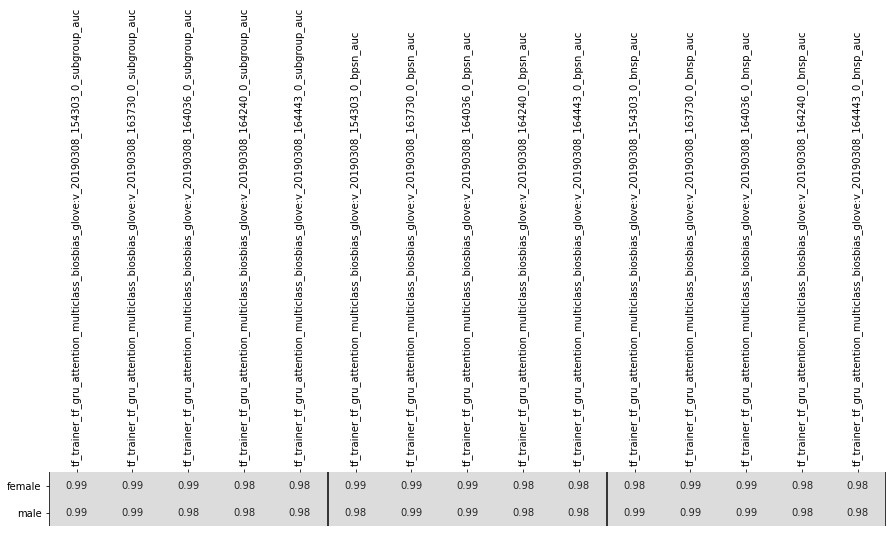

Class 1


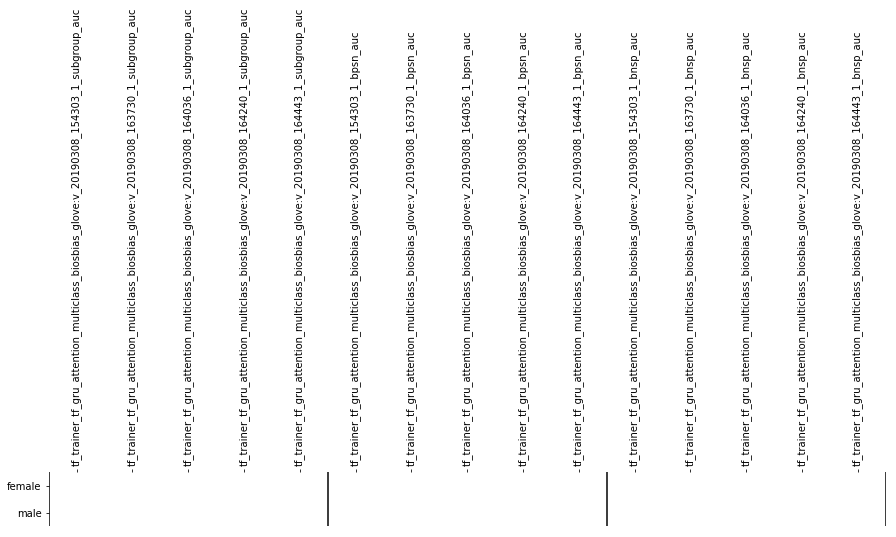

Class 2


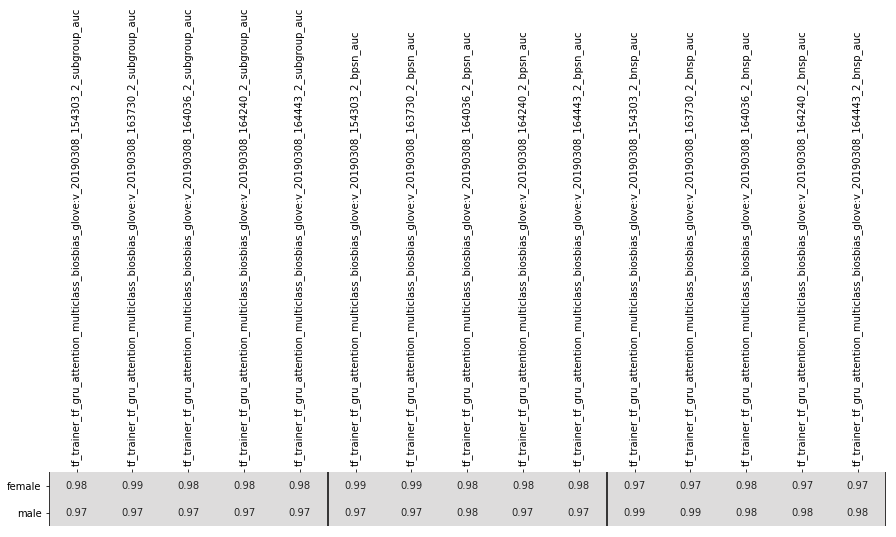

Class 3


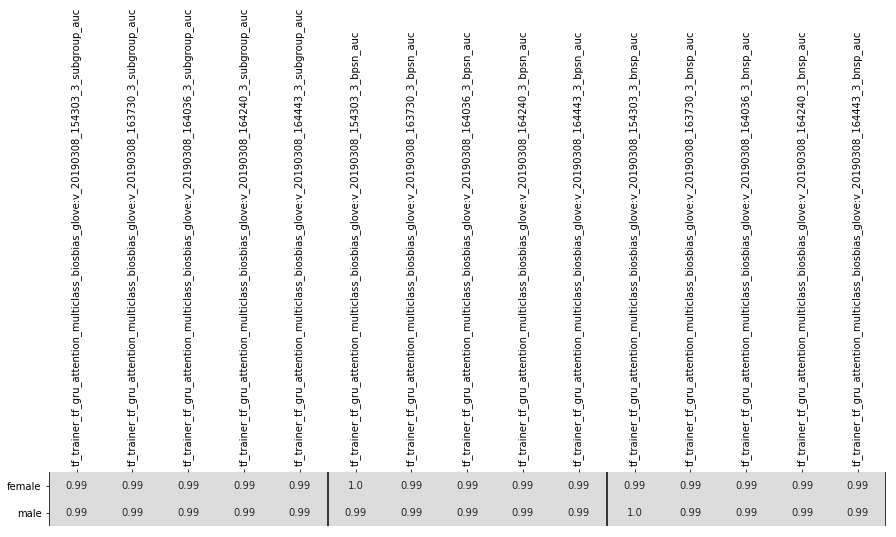

Class 4


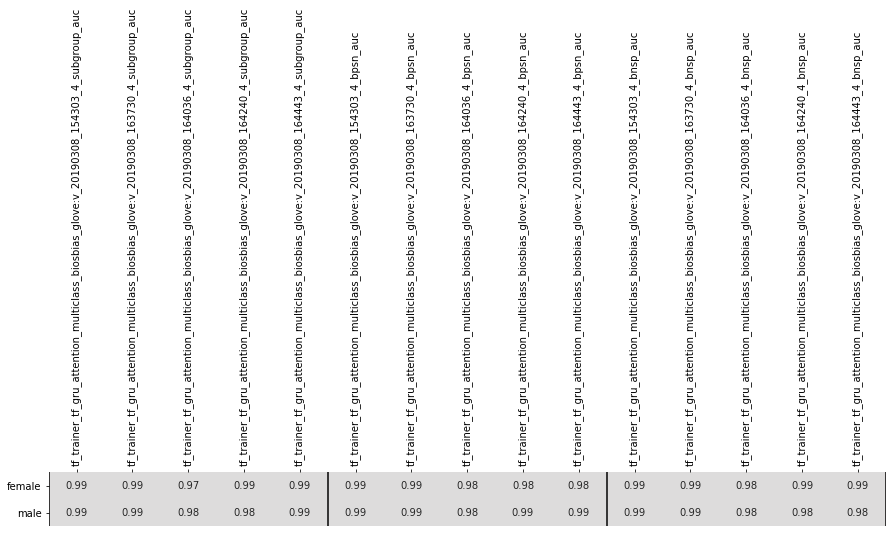

Class 5


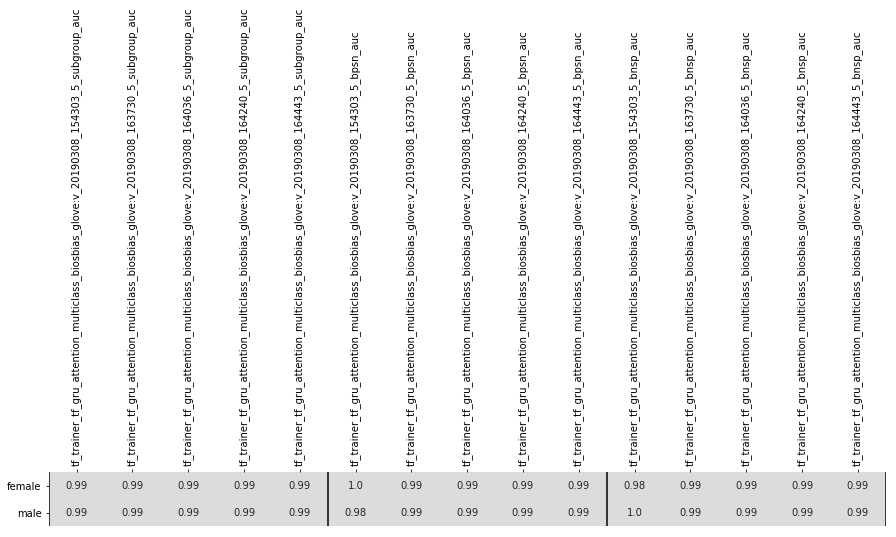

Class 6


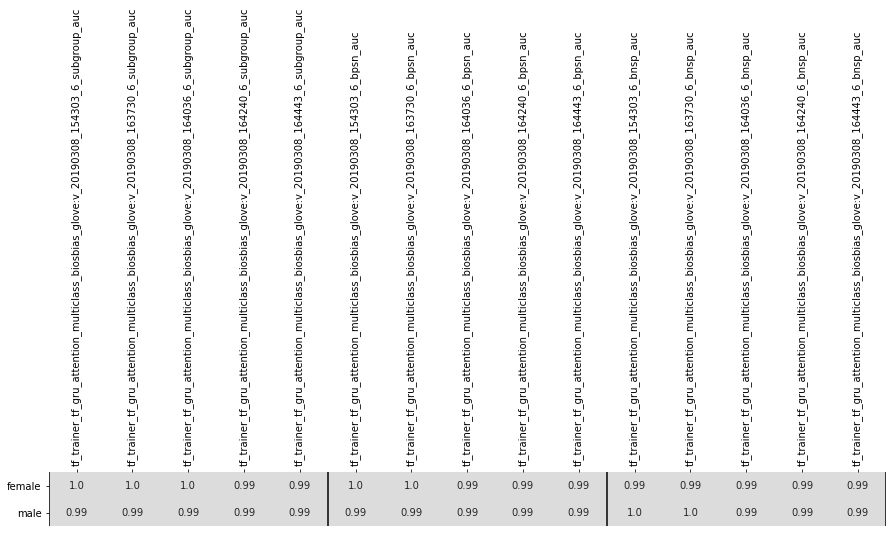

Class 7


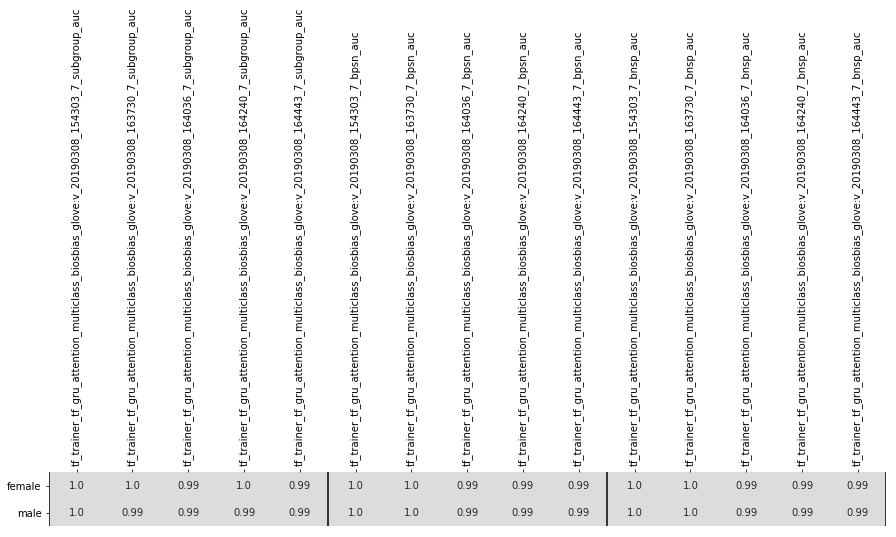

Class 8


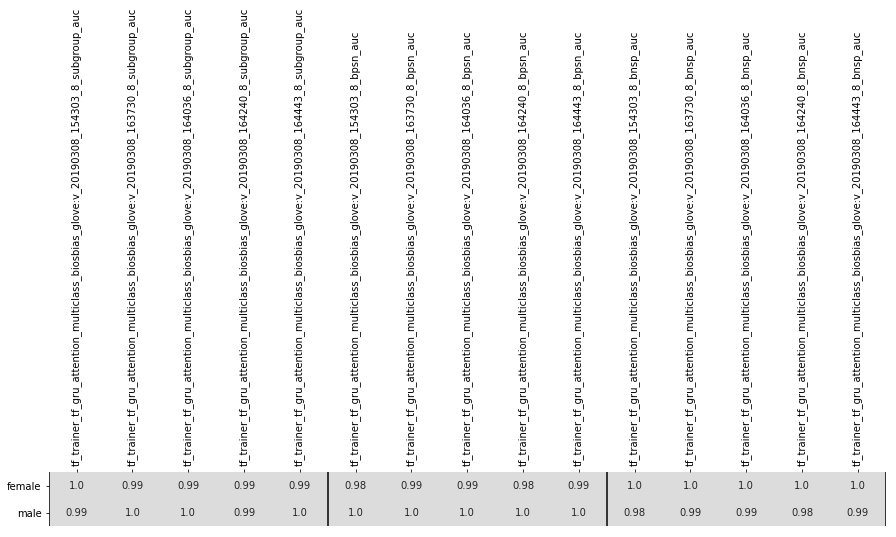

Class 9


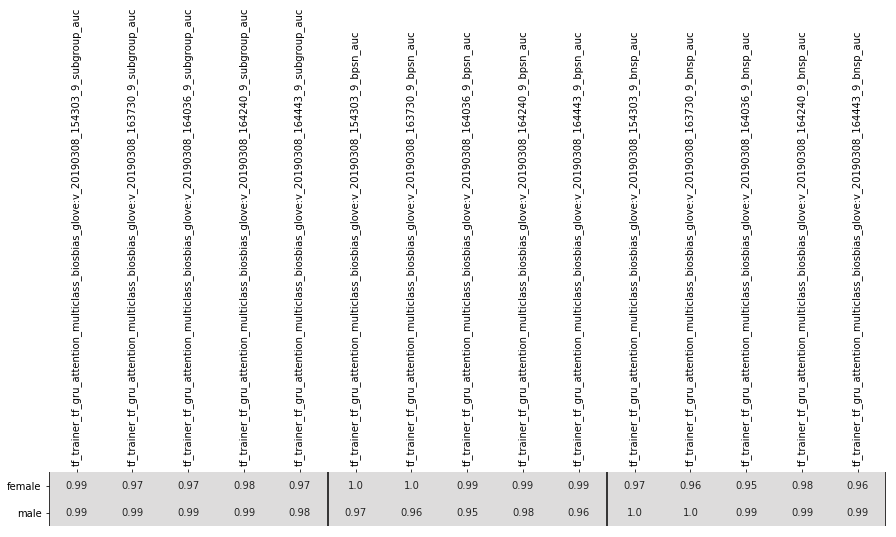

Class 10


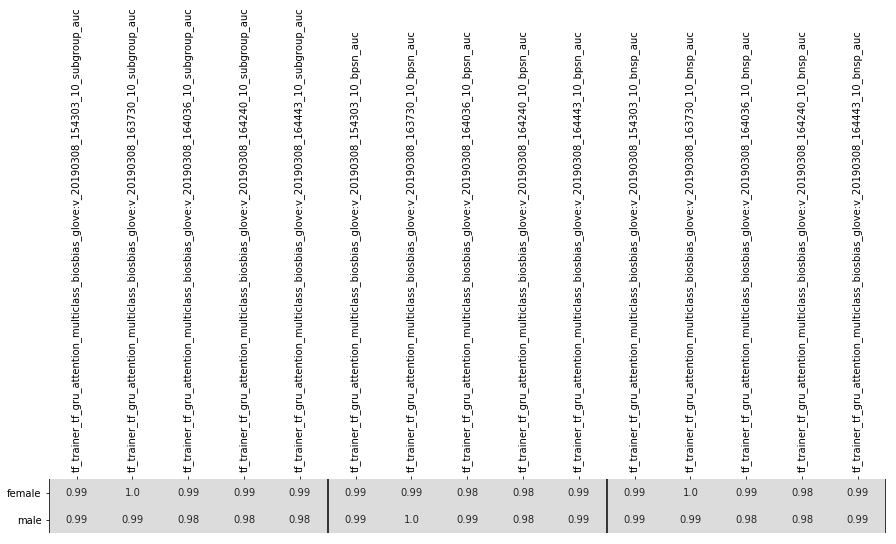

Class 11


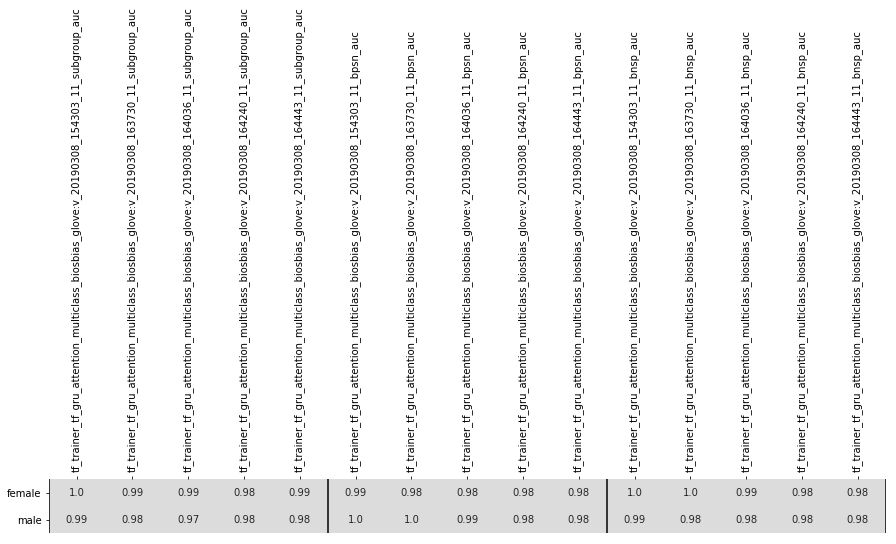

Class 12


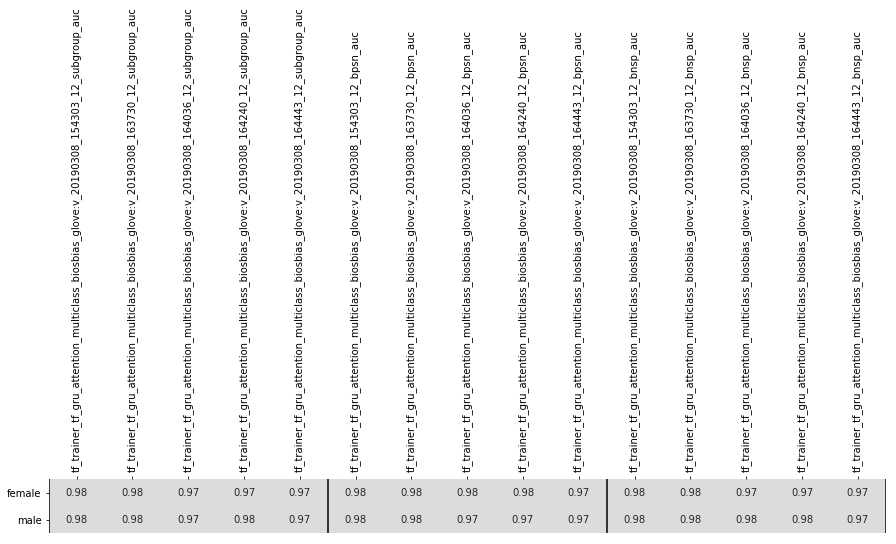

Class 13


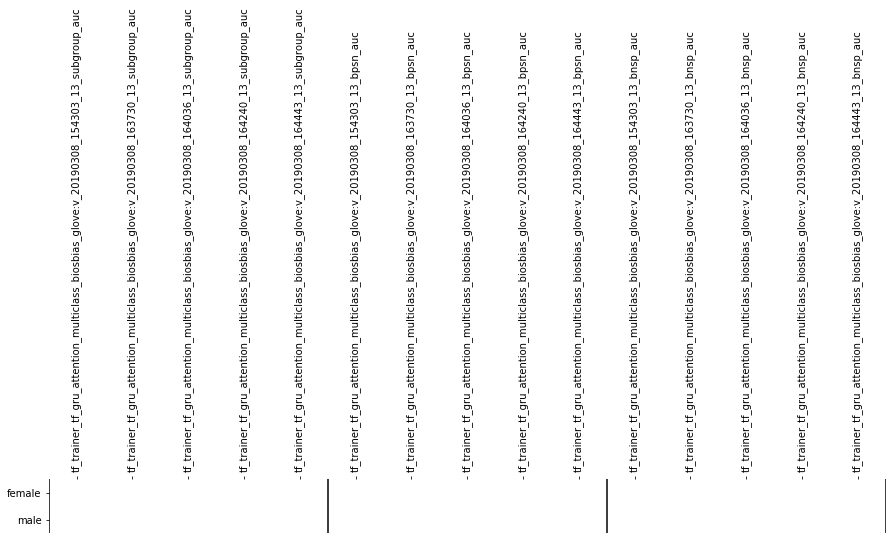

Class 14


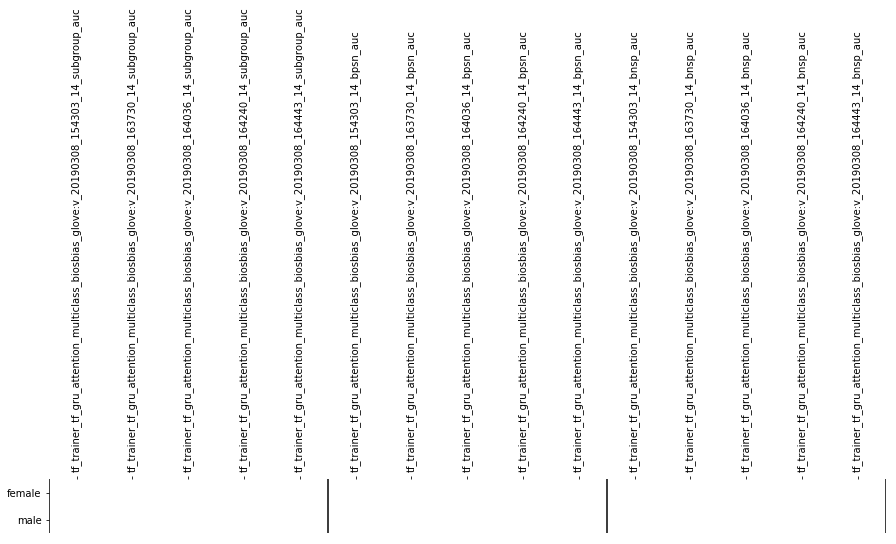

Class 15


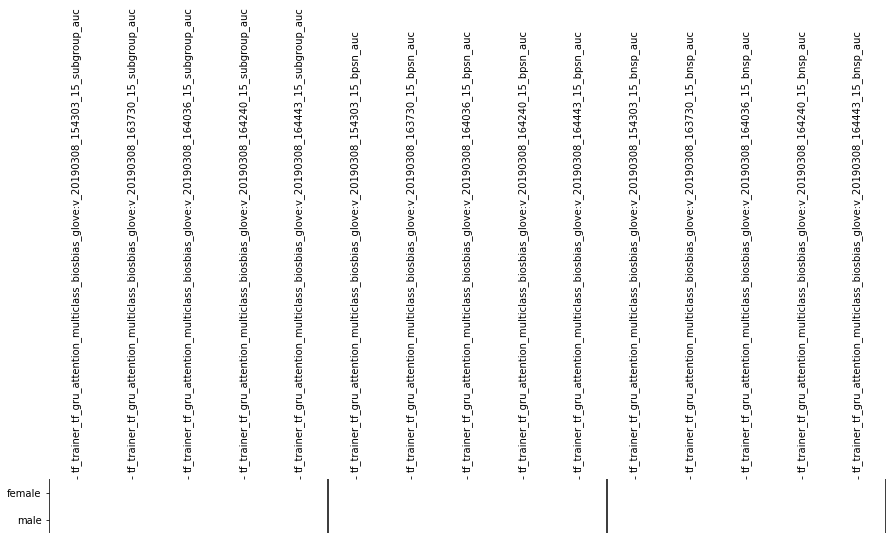

Class 16


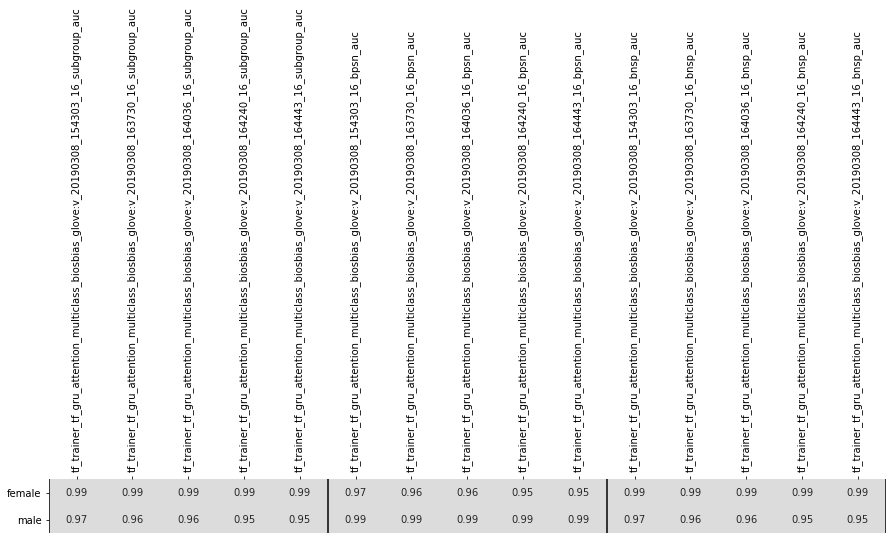

Class 17


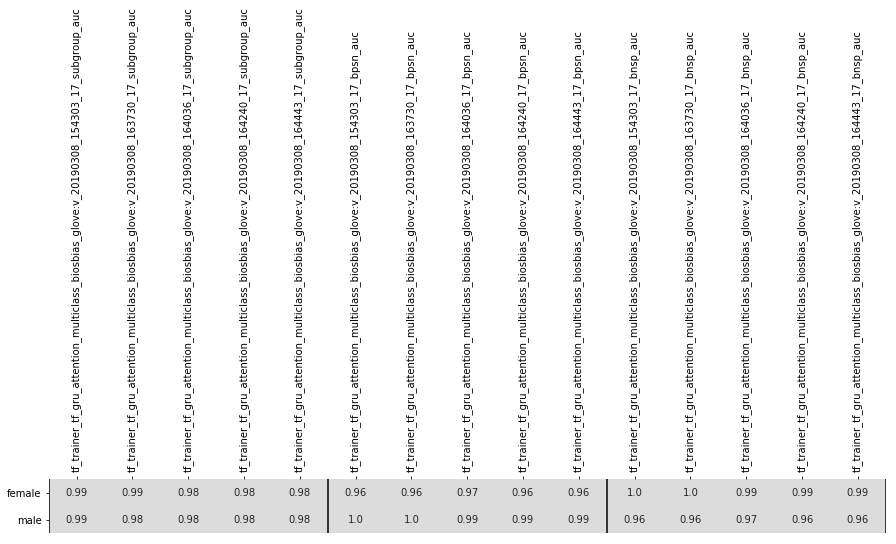

Class 18


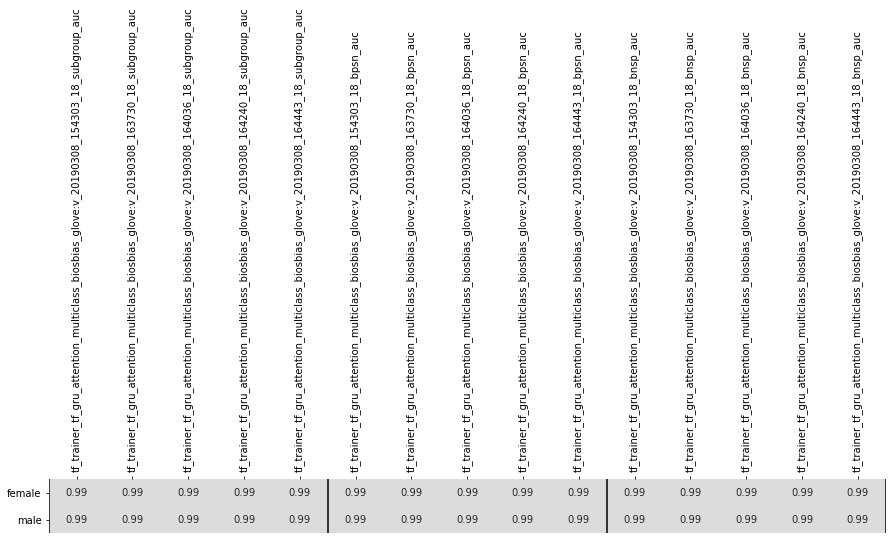

Class 19


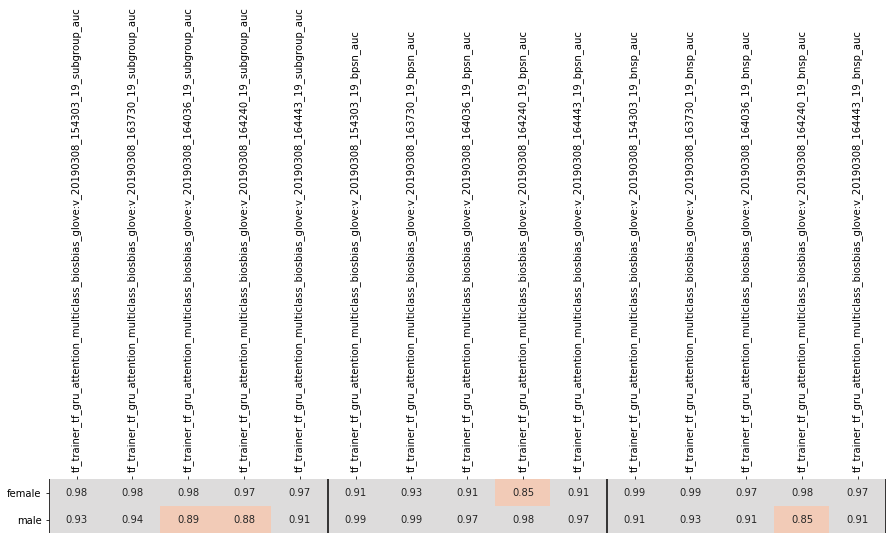

Class 20


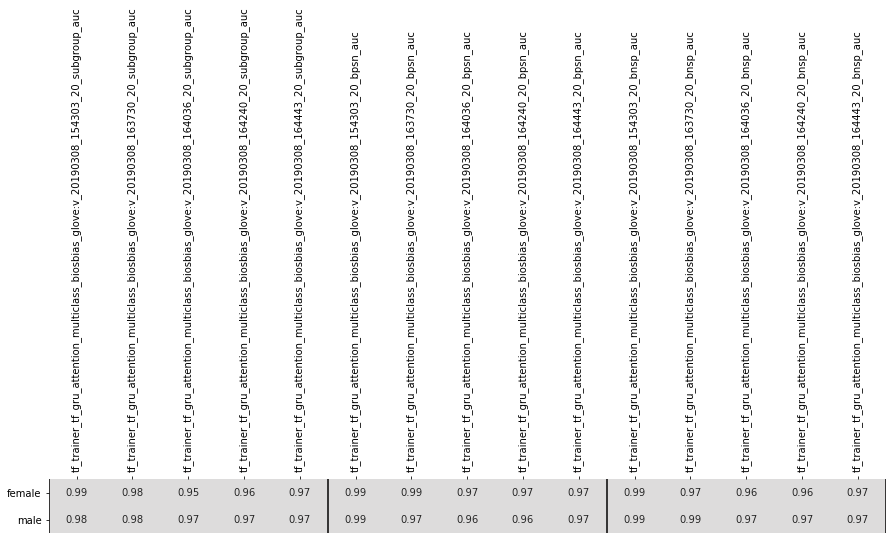

Class 21


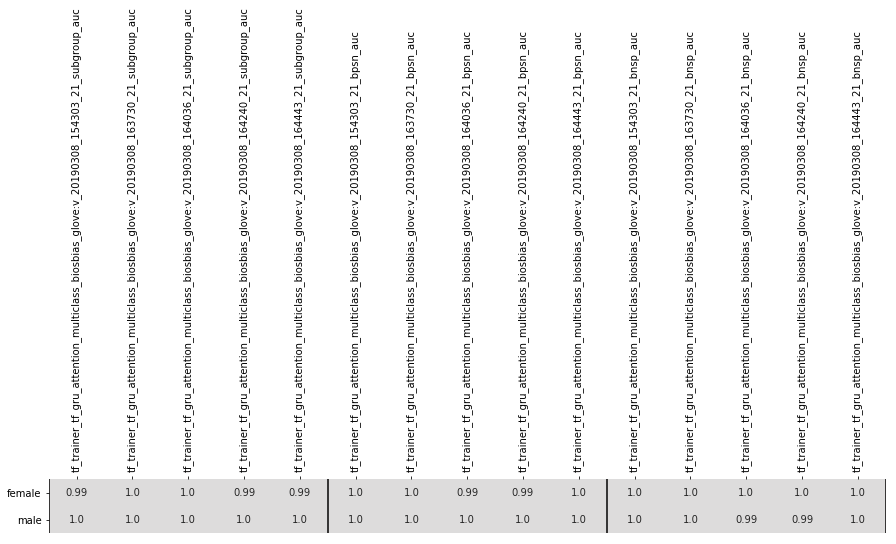

Class 22


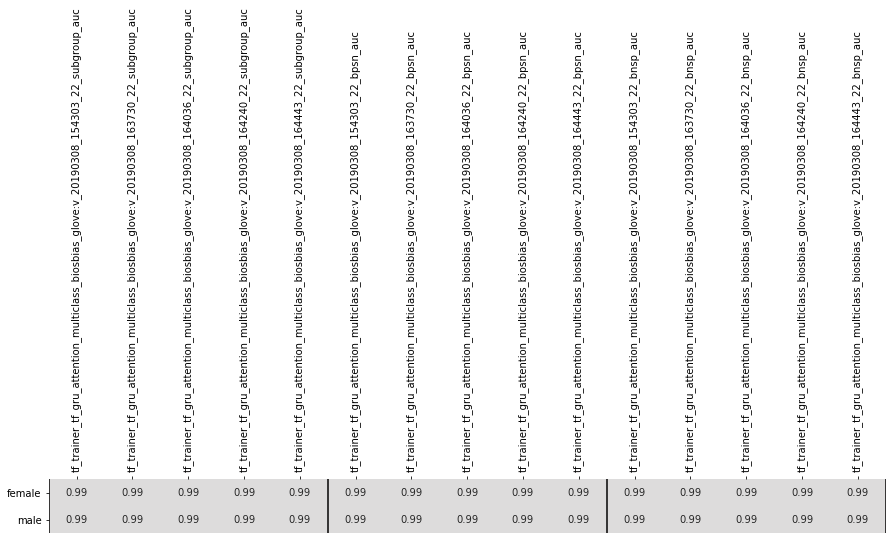

Class 23


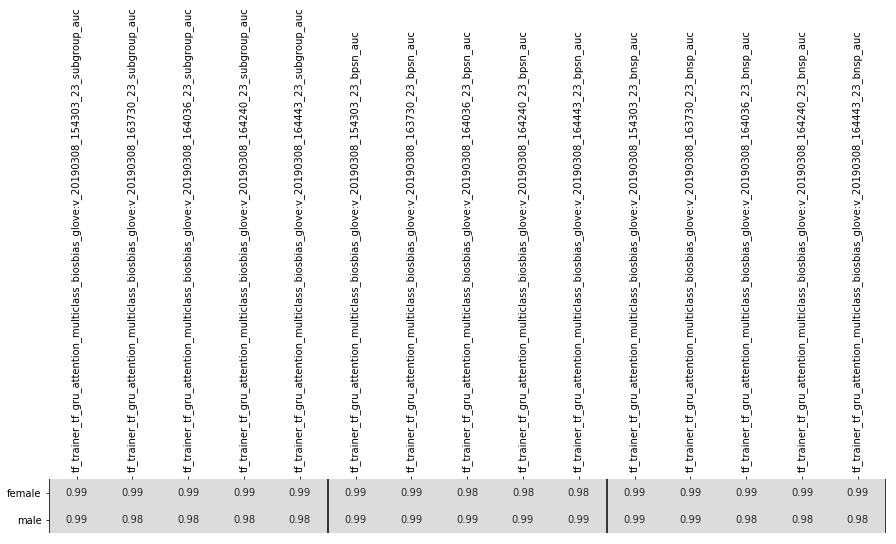

Class 24


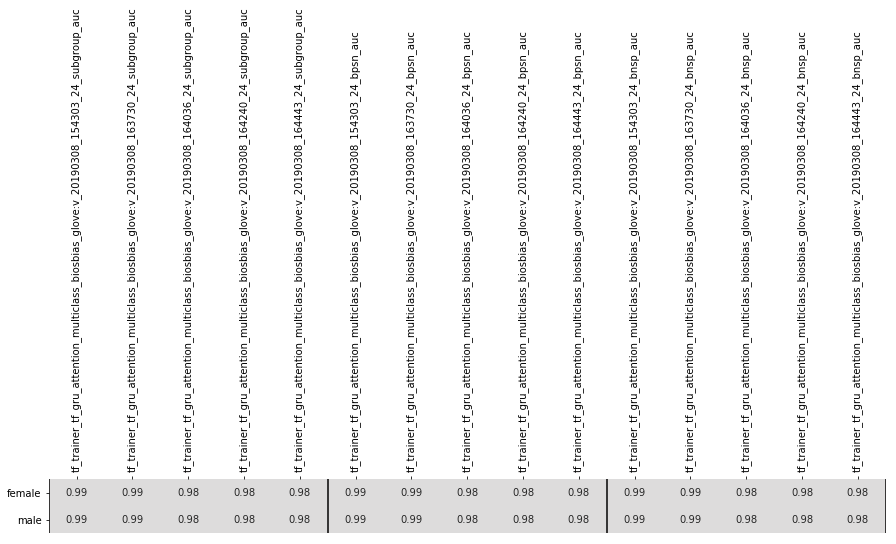

Class 25


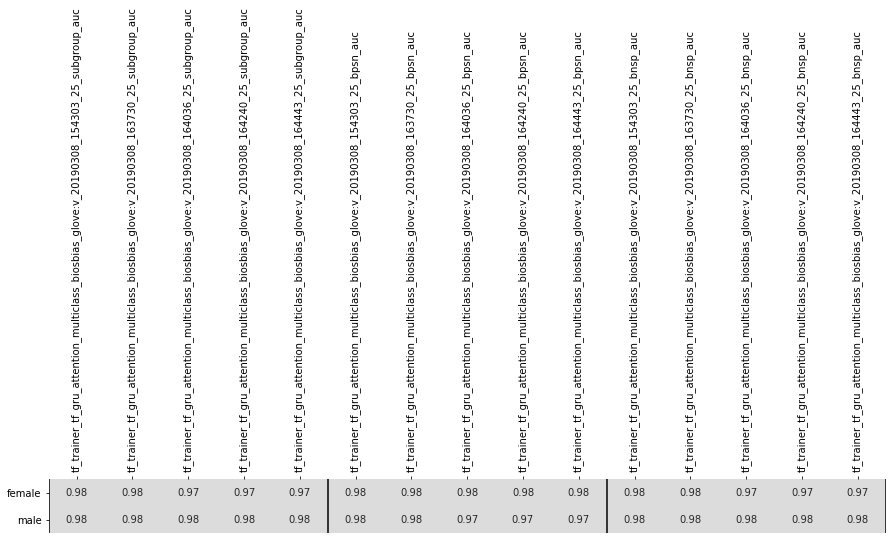

Class 26


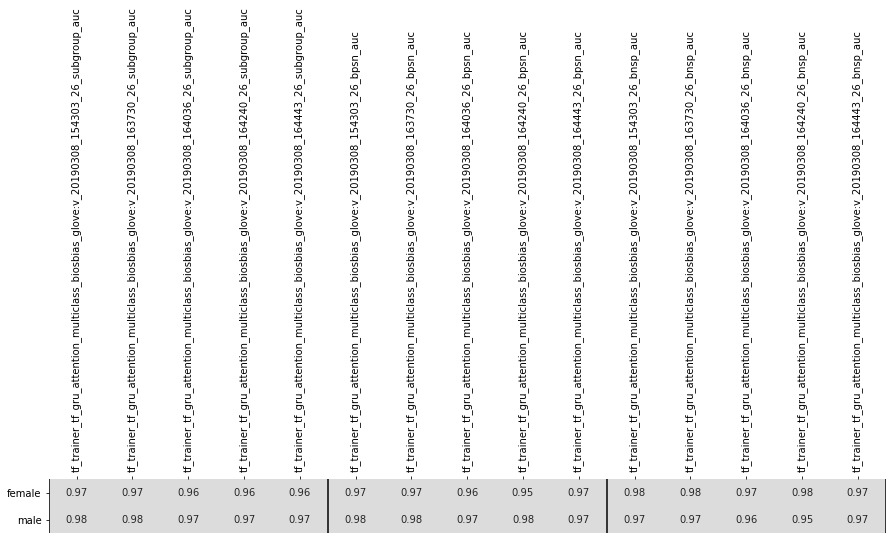

Class 27


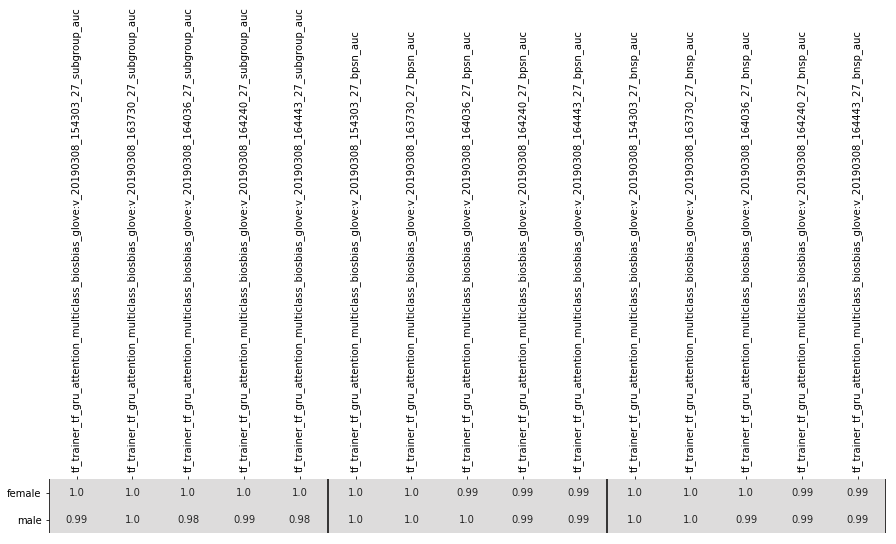

Class 28


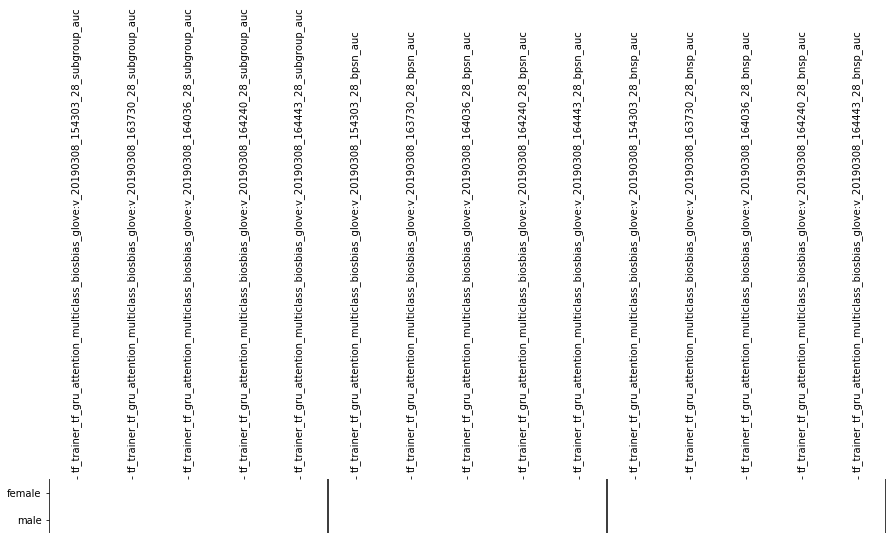

Class 29


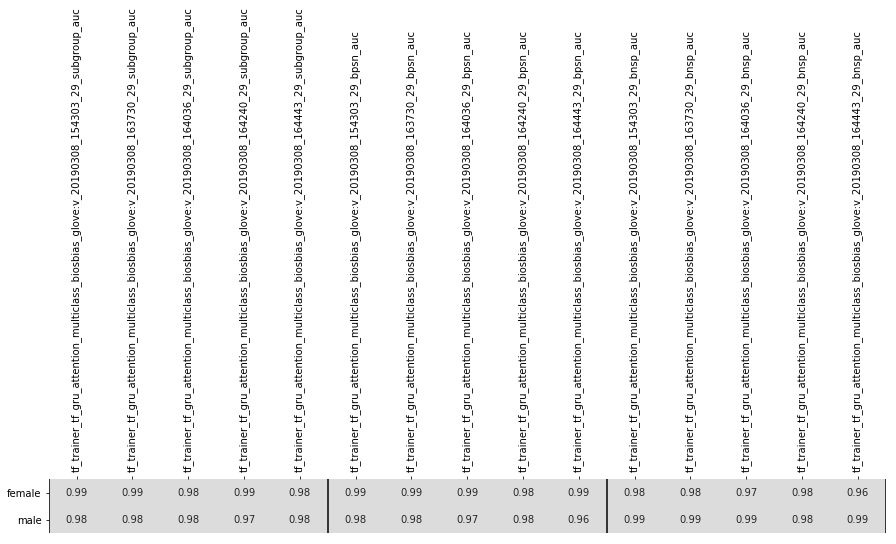

Class 30


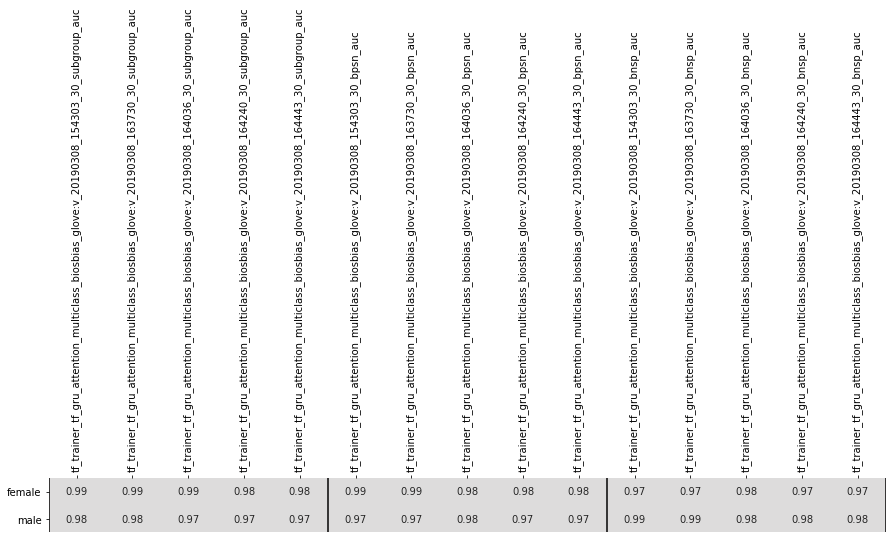

Class 31


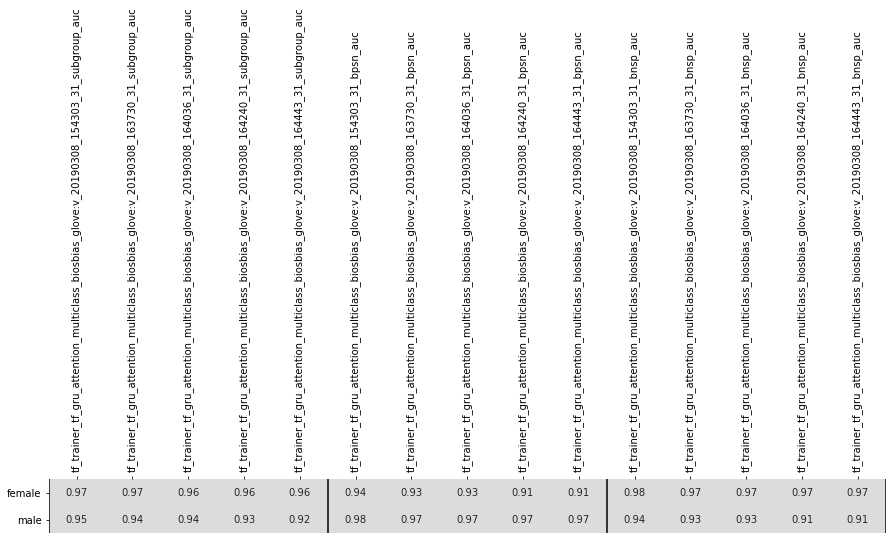

Class 32


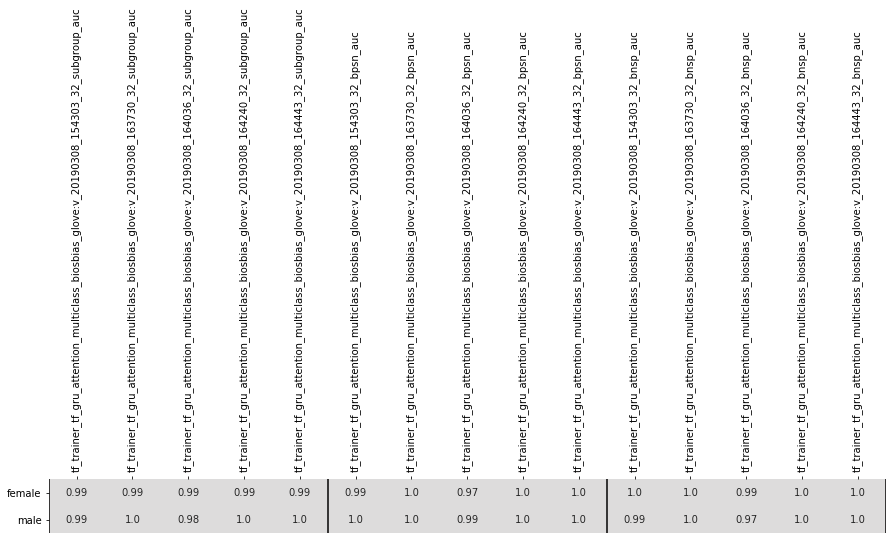

In [42]:
for _class in CLASS_NAMES:
    print('Class {}'.format(_class))
    class_models = ['{}_{}'.format(_model, _class) for _model in MODEL_NAMES]
    model_bias_analysis.plot_auc_heatmap(bias_metrics[_class], class_models)
    plt.show()

Class 0


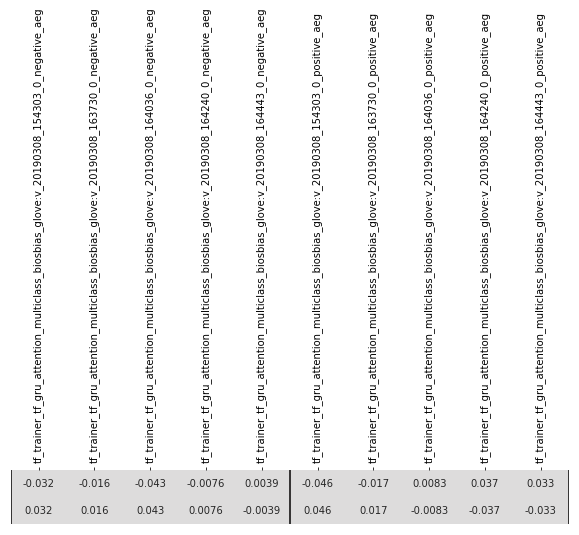

Class 1
Skipping class 1...
Class 2


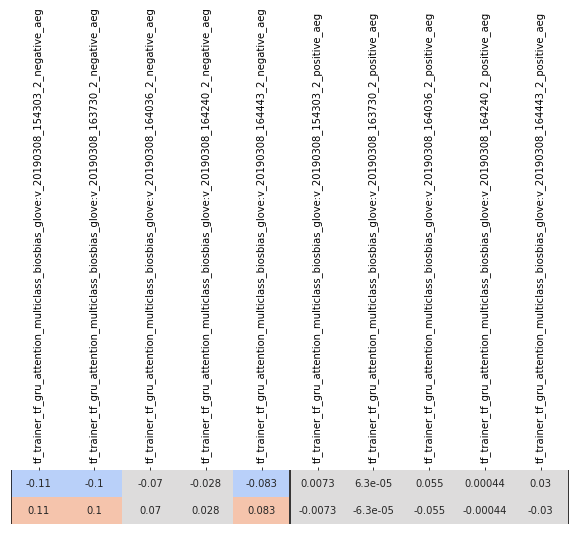

Class 3


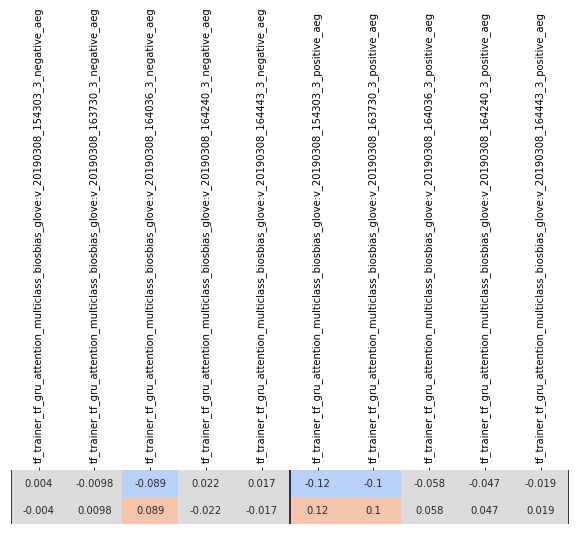

Class 4


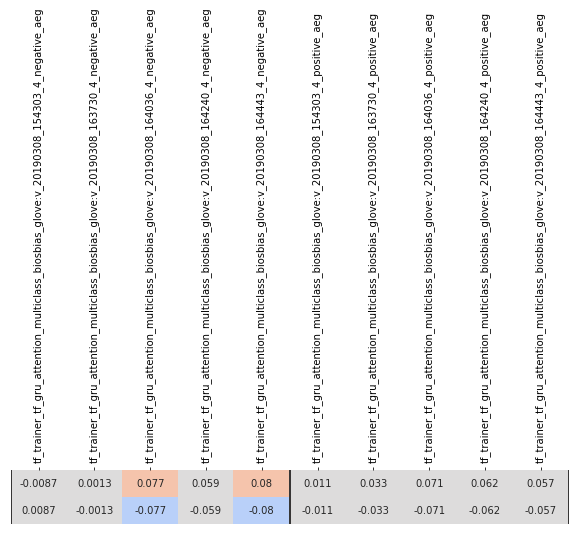

Class 5


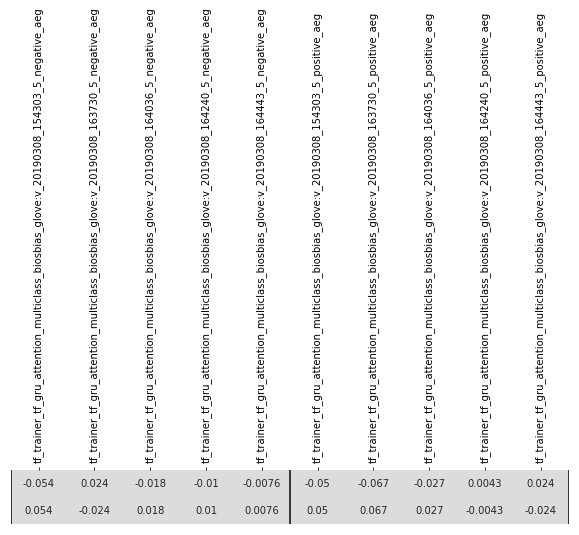

Class 6


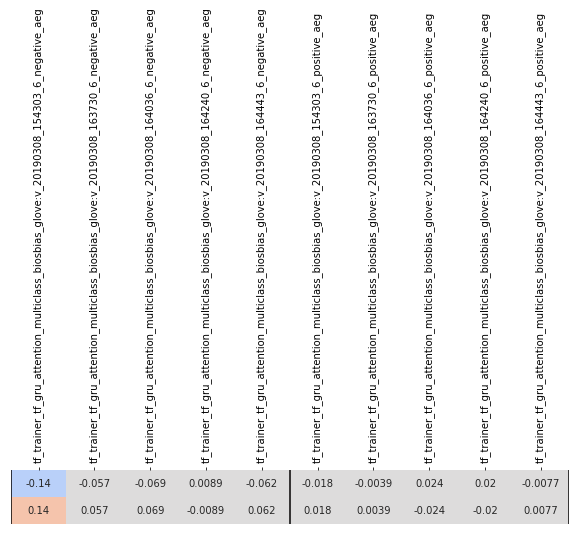

Class 7


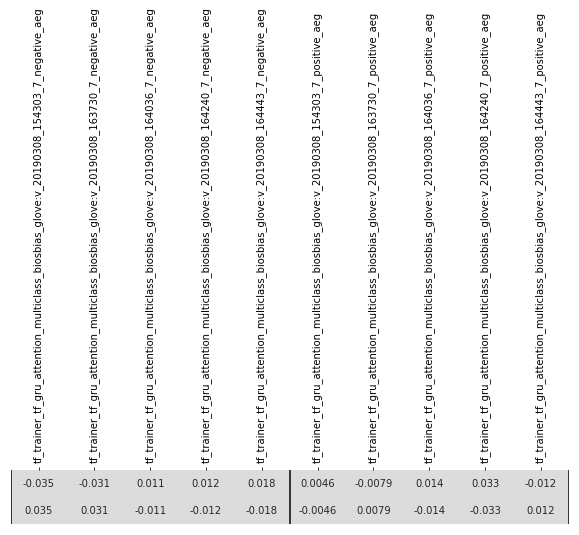

Class 8


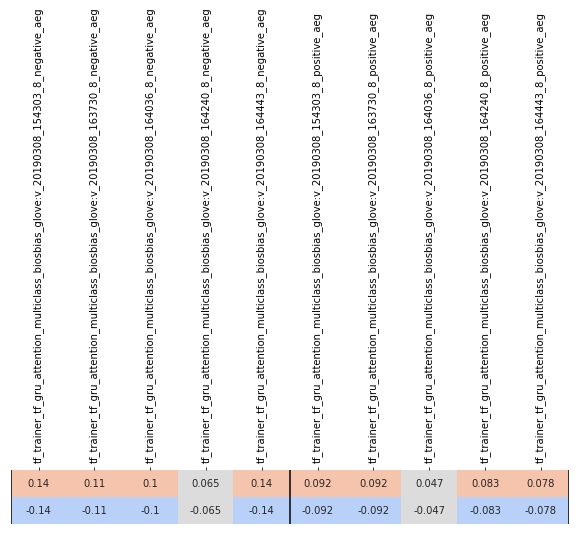

Class 9


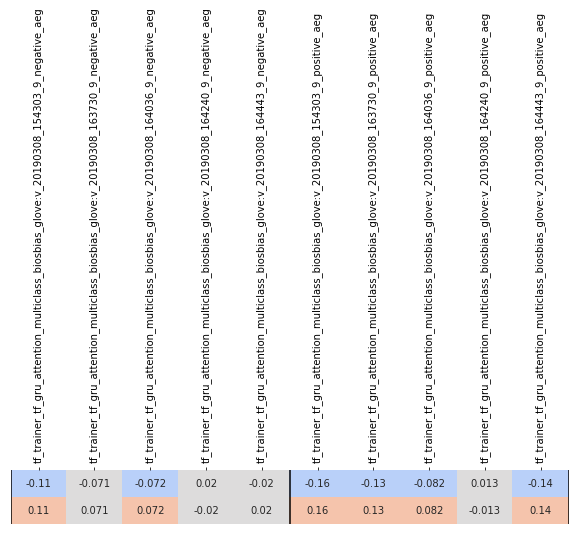

Class 10


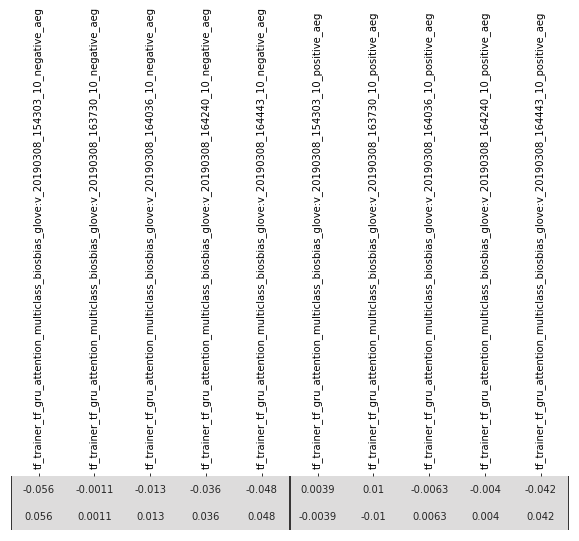

Class 11


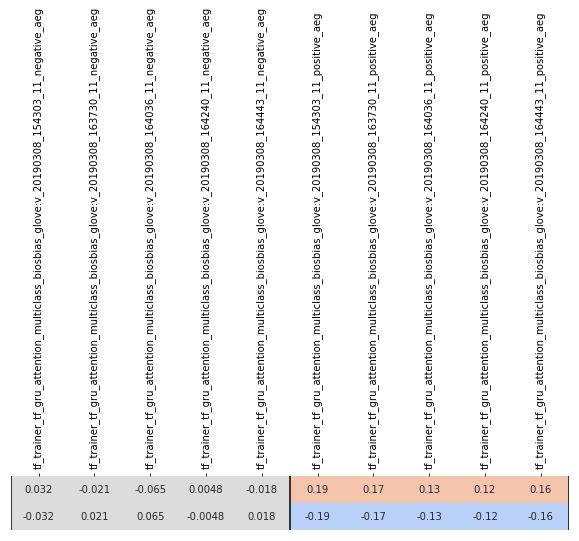

Class 12


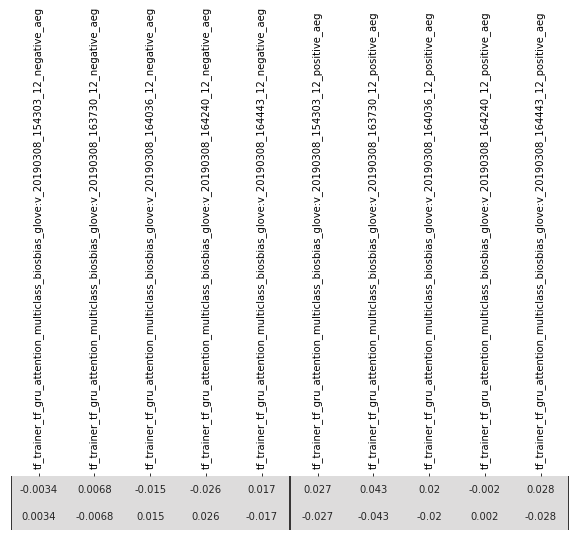

Class 13
Skipping class 13...
Class 14
Skipping class 14...
Class 15
Skipping class 15...
Class 16


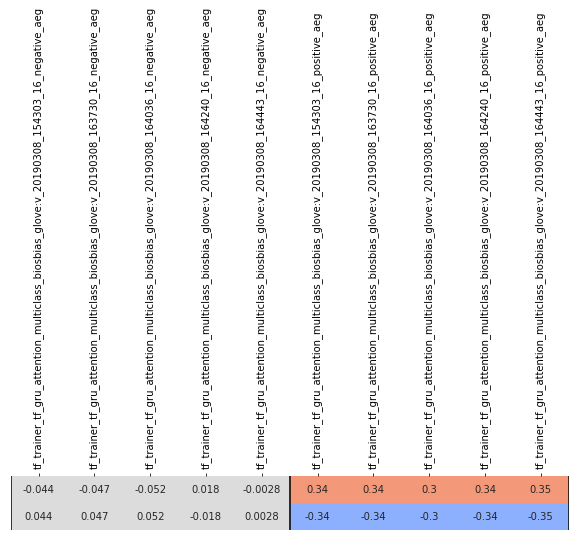

Class 17


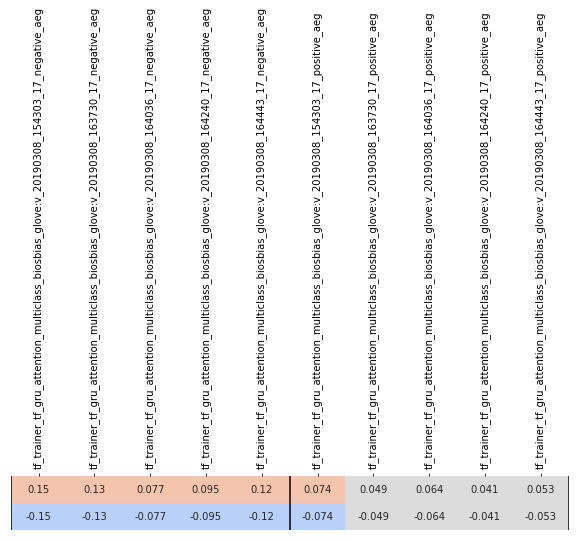

Class 18


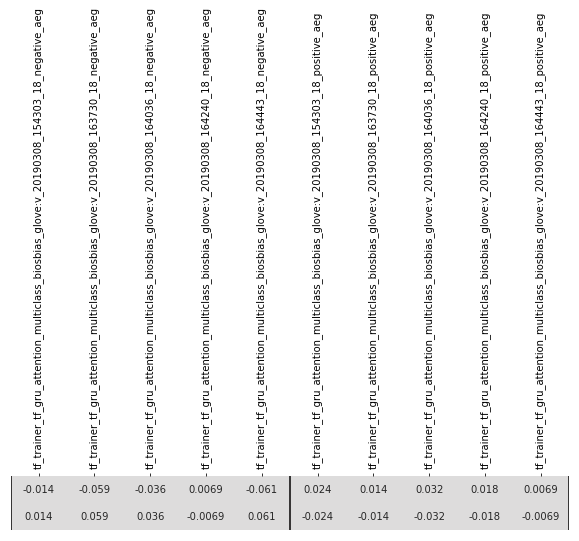

Class 19


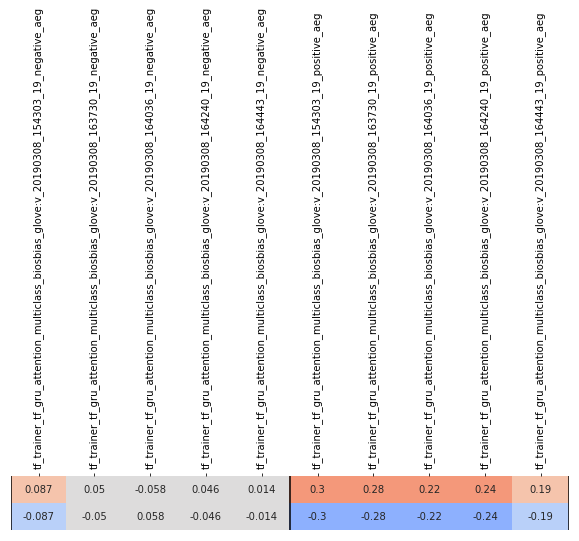

Class 20


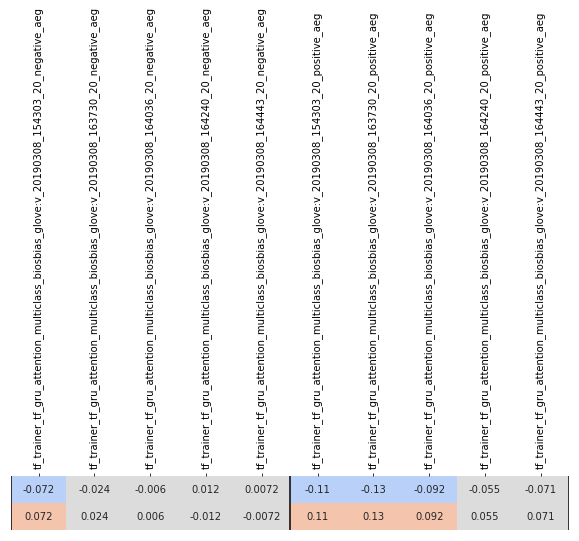

Class 21


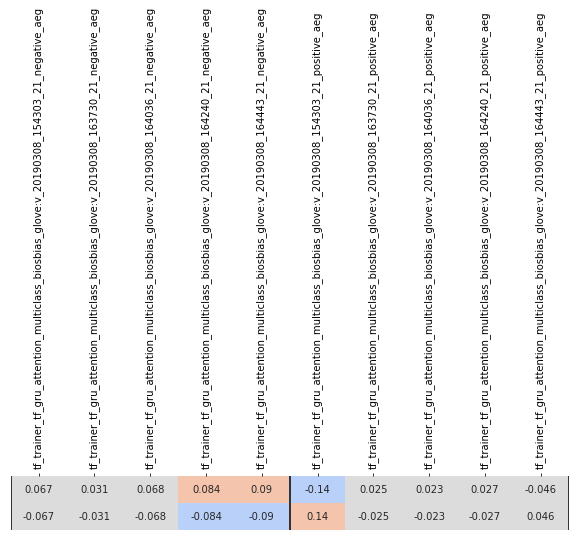

Class 22


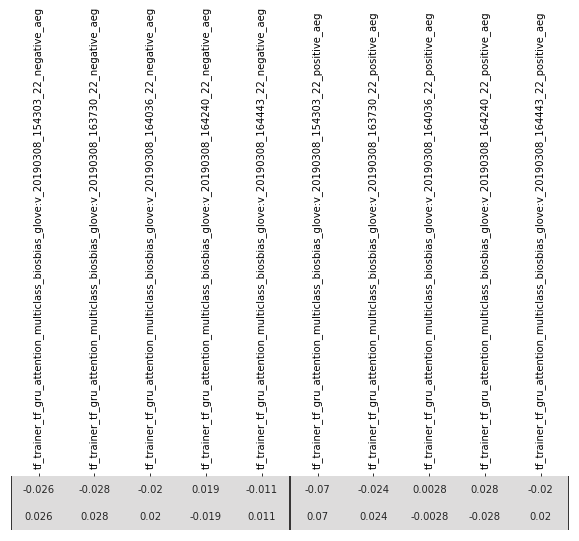

Class 23


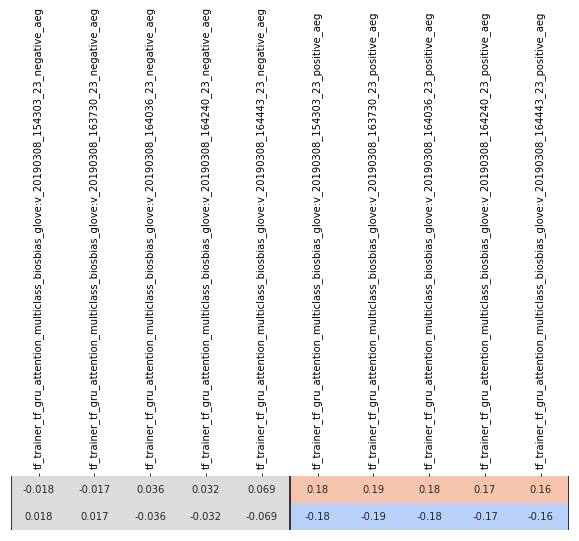

Class 24


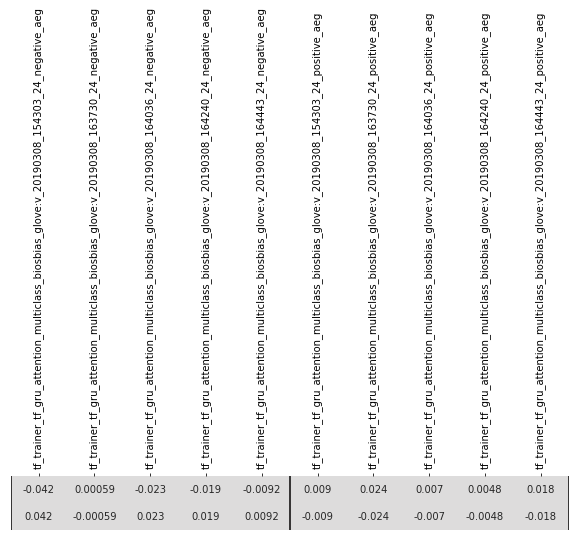

Class 25


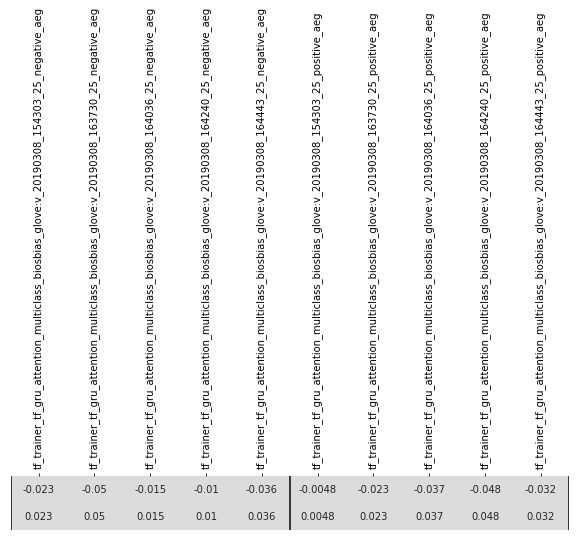

Class 26


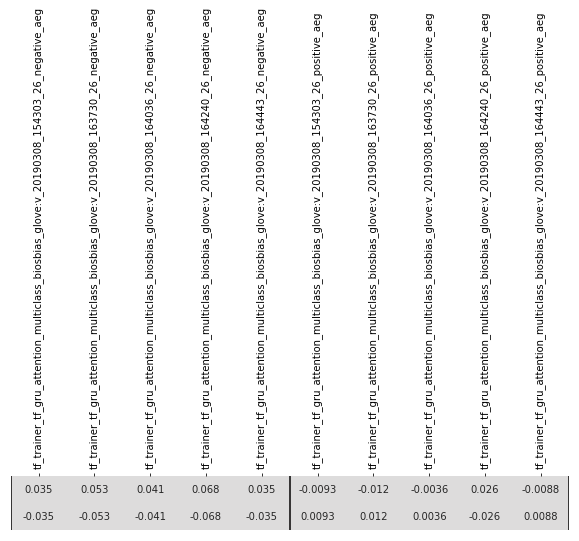

Class 27


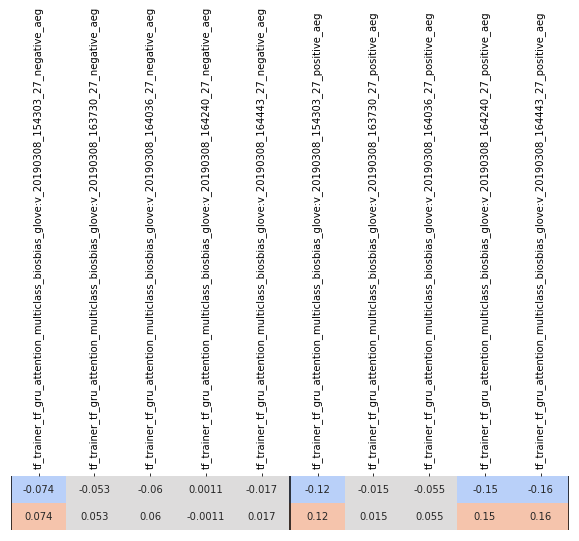

Class 28
Skipping class 28...
Class 29


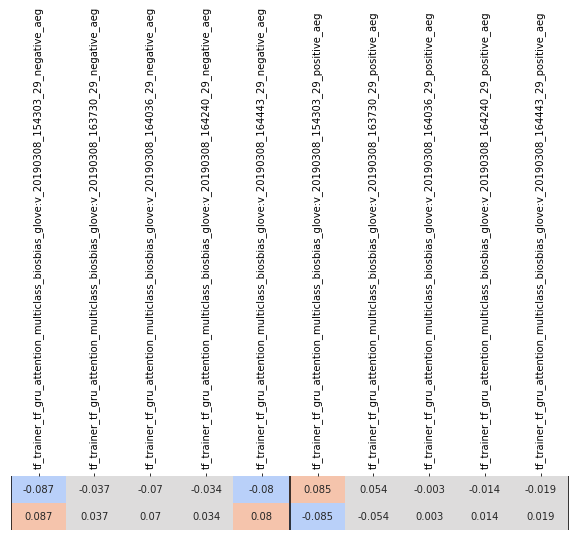

Class 30


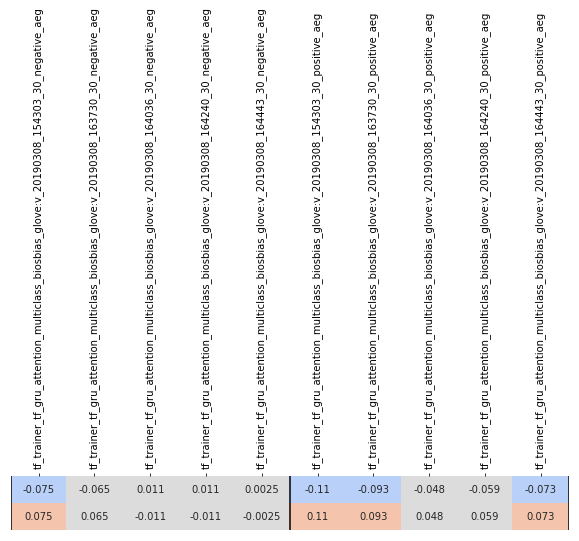

Class 31


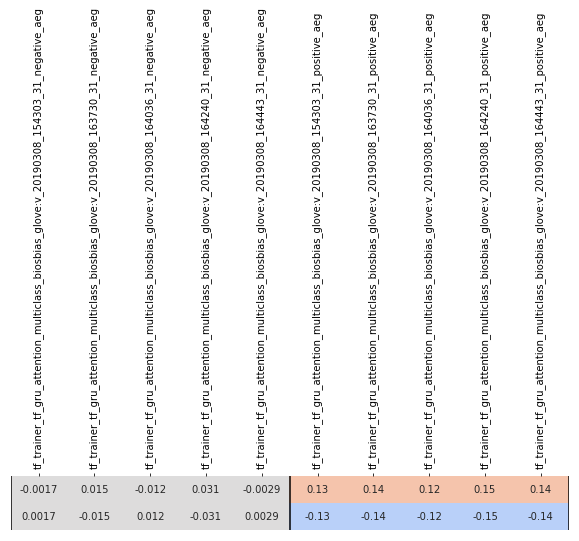

Class 32


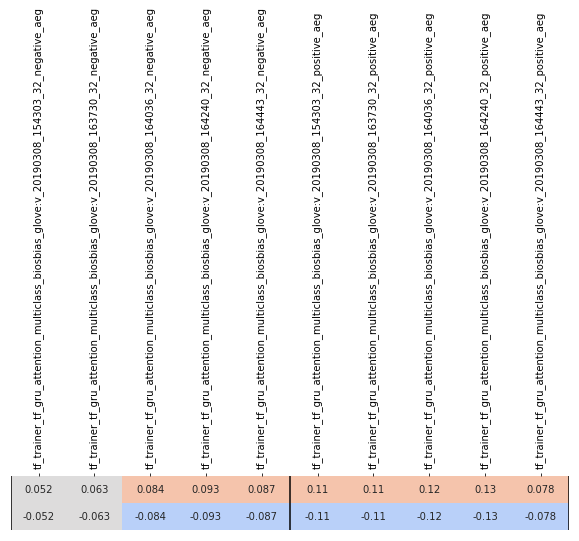

In [43]:
for _class in CLASS_NAMES:
    try:
        print('Class {}'.format(_class))
        class_models = ['{}_{}'.format(_model, _class) for _model in MODEL_NAMES]
        model_bias_analysis.plot_aeg_heatmap(bias_metrics[_class], class_models)
        plt.show()
    except:
        print('Skipping class {}...'.format(_class))

## TPR Plots

In [44]:
# Gender ratios of classes
gender_counts = test_bias_df.groupby('label').gender.value_counts().reset_index(name = 'count')

In [45]:
def frac_female(df):
    m_count = df[df['gender'] == "M"]['count'].values[0]
    f_count = df[df['gender'] == "F"]['count'].values[0]
    return {'label': df['label'].values[0], 'frac_female': f_count/(m_count+f_count)}

In [46]:
frac_female_df = pd.DataFrame(list(gender_counts.groupby('label', as_index = False).apply(frac_female)))

In [47]:
frac_female_df

,frac_female,label
0,0.355311,0
1,0.206704,2
2,0.359738,3
3,0.283871,4
4,0.205479,5
5,0.148472,6
6,0.349866,7
7,0.900000,8
8,0.142857,9
9,0.342029,10


In [48]:
def compute_tpr(df, _class, _model, threshold = 0.5):
    tpr = metrics.recall_score(df['label_{}'.format(_class)],
                               df['{}_{}'.format(_model,_class)] > threshold)
    return tpr
    
def compute_tpr_by_gender(df, _class, _model, threshold = 0.5):
    tpr_m = compute_tpr(df.query('gender == "M"'), _class, _model, threshold)
    tpr_f = compute_tpr(df.query('gender == "F"'), _class, _model, threshold)
    return {'M': tpr_m, 'F': tpr_f}

In [49]:
compute_tpr(test_bias_df, 4, 'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303')

0.6774193548387096

In [50]:
compute_tpr_by_gender(test_bias_df, 4, 'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303')

{'F': 0.7045454545454546, 'M': 0.6666666666666666}

In [51]:
tpr_df = pd.DataFrame()
for _class in frac_female_df.label:
    row = {}
    row['label'] = _class
    for _model in MODEL_NAMES:
        row['{}_tpr'.format(_model)] = compute_tpr(test_bias_df, _class, _model)
        gender_tprs = compute_tpr_by_gender(test_bias_df, _class, _model)
        row['{}_tpr_F'.format(_model)] = gender_tprs['F']
        row['{}_tpr_M'.format(_model)] = gender_tprs['M']
        row['{}_tpr_gender_gap'.format(_model)] = gender_tprs['F'] - gender_tprs['M']
    tpr_df = tpr_df.append(row, ignore_index = True)

In [52]:
results_df = pd.merge(tpr_df, frac_female_df, on = 'label')

In [53]:
TITLE_LABELS = [
    'accountant', 'acupuncturist', 'architect', 'attorney', 'chiropractor', 'comedian', 'composer', 'dentist',
    'dietitian', 'dj', 'filmmaker', 'interior_designer', 'journalist', 'landscape_architect', 'magician',
    'massage_therapist', 'model', 'nurse', 'painter', 'paralegal', 'pastor', 'personal_trainer',
    'photographer', 'physician', 'poet', 'professor', 'psychologist', 'rapper',
    'real_estate_broker', 'software_engineer', 'surgeon', 'teacher', 'yoga_teacher']

In [54]:
results_df['label_profession'] = results_df['label'].apply(lambda x: TITLE_LABELS[int(x)])

In [55]:
results_df.columns

Index([u'label',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_tpr',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_tpr_F',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_tpr_M',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_tpr_gender_gap',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730_tpr',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730_tpr_F',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730_tpr_M',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730_tpr_gender_gap',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036_tpr',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036_tpr_F',
       u'tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036_

In [56]:
def plot_tpr_gap(df, _model):
    fig, ax = plt.subplots(figsize=(15, 6))
    x = 'frac_female'
    y = '{}_tpr_gender_gap'.format(_model)
    p1 = sns.regplot(x = x, y = y, data = df)
    p1.set(xlabel = "% Female", ylabel = "TPR Gender Gap", title = _model)

    for line in range(0,df.shape[0]):
         p1.text(results_df[x][line]+0.01, df[y][line], df['label_profession'][line], horizontalalignment='left', size='medium', color='black')
    plt.show()

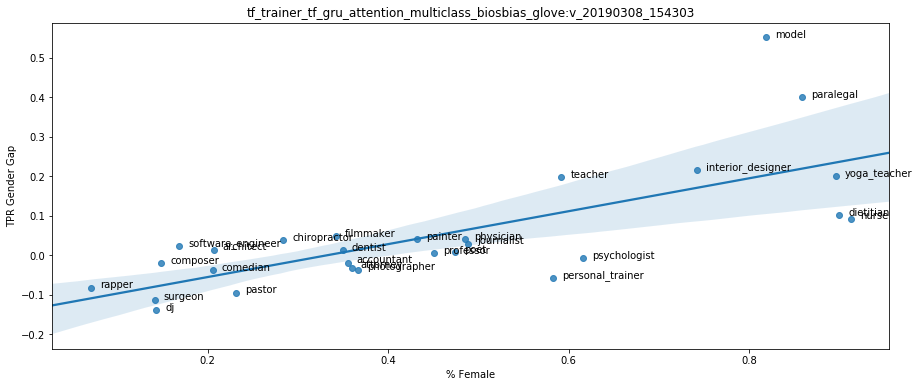

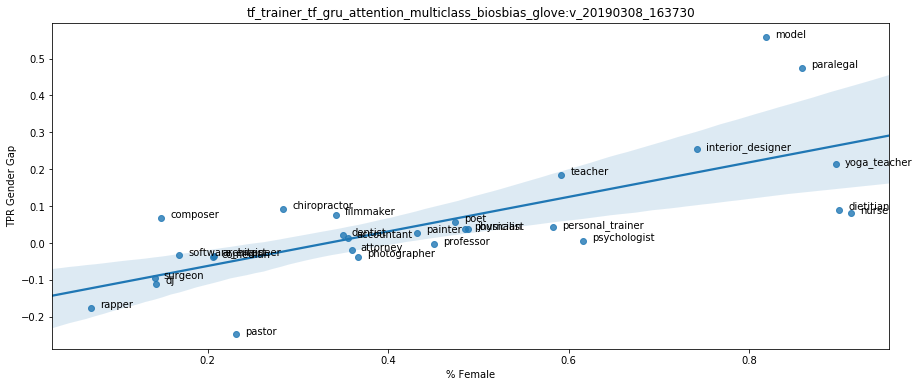

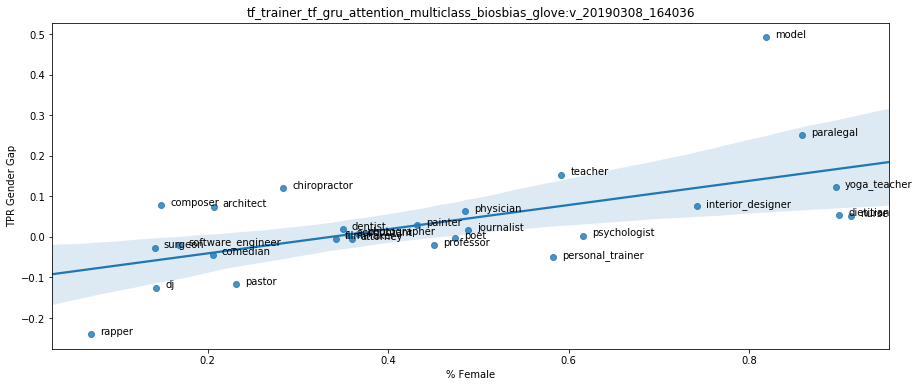

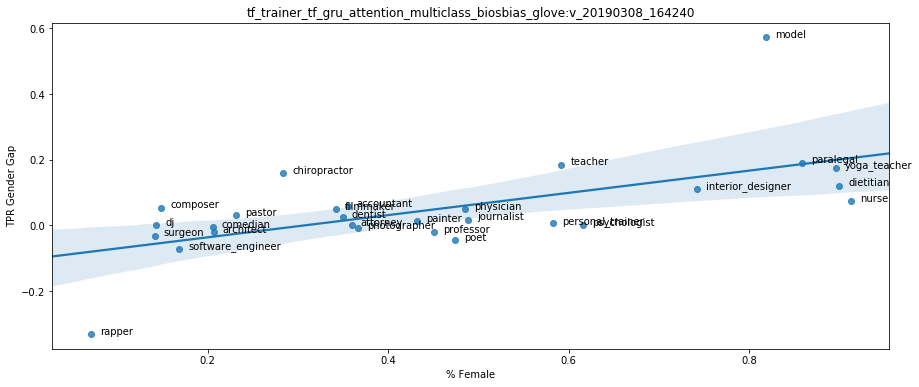

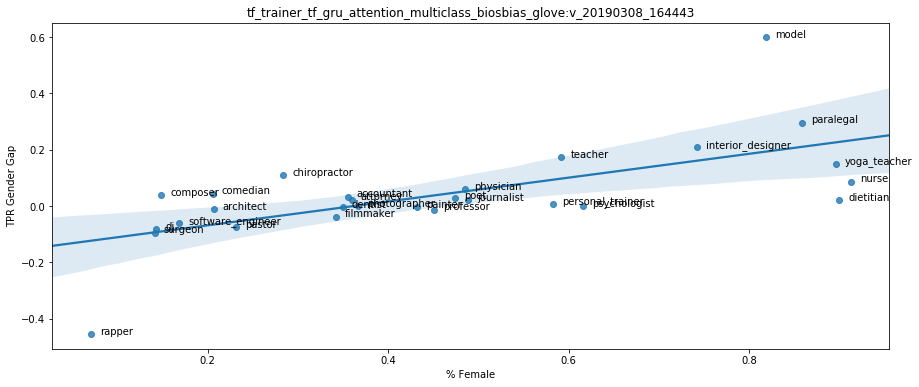

In [57]:
for _model in MODEL_NAMES:
    plot_tpr_gap(results_df, _model)

In [64]:
results_df[['frac_female']+['{}_tpr_gender_gap'.format(_model) for _model in MODEL_NAMES]].corr()[['frac_female']]
    

,frac_female
frac_female,1.000000
tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_154303_tpr_gender_gap,0.722367
tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_163730_tpr_gender_gap,0.725472
tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164036_tpr_gender_gap,0.602035
tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164240_tpr_gender_gap,0.614252
tf_trainer_tf_gru_attention_multiclass_biosbias_glove:v_20190308_164443_tpr_gender_gap,0.652515


In [92]:
gender_gap_df = results_df[['label_profession', 'frac_female']+['{}_tpr_gender_gap'.format(_model) for _model in MODEL_NAMES]]
gender_gap_df.columns = ['label_profession', 'frac_female', 'glove_untuned', 'glove_tuned', 'debiased_tuned', 'debiased_untuned', 'super_debiased']

In [93]:
gender_gap_df.sort_values('frac_female', ascending = False)

,label_profession,frac_female,glove_untuned,glove_tuned,debiased_tuned,debiased_untuned,super_debiased
13,nurse,0.913333,0.092270,0.080760,0.050159,0.074396,0.085720
7,dietitian,0.900000,0.100529,0.089947,0.052910,0.121693,0.021164
27,yoga_teacher,0.896552,0.200855,0.213675,0.123932,0.175214,0.149573
15,paralegal,0.858974,0.398915,0.474898,0.251018,0.191316,0.295794
12,model,0.819407,0.550668,0.557247,0.491457,0.572418,0.598979
10,interior_designer,0.742424,0.216086,0.254502,0.075630,0.111645,0.208884
22,psychologist,0.615632,-0.007669,0.005552,0.002412,0.000465,-0.000019
26,teacher,0.591990,0.197421,0.184529,0.153478,0.184899,0.172668
17,personal_trainer,0.583333,-0.057143,0.042857,-0.050000,0.007143,0.007143
11,journalist,0.488511,0.028522,0.037828,0.016368,0.017243,0.021560


In [95]:
gender_gap_df.sort_values(by = 'glove_untuned', ascending = False)

,label_profession,frac_female,glove_untuned,glove_tuned,debiased_tuned,debiased_untuned,super_debiased
12,model,0.819407,0.550668,0.557247,0.491457,0.572418,0.598979
15,paralegal,0.858974,0.398915,0.474898,0.251018,0.191316,0.295794
10,interior_designer,0.742424,0.216086,0.254502,0.075630,0.111645,0.208884
27,yoga_teacher,0.896552,0.200855,0.213675,0.123932,0.175214,0.149573
26,teacher,0.591990,0.197421,0.184529,0.153478,0.184899,0.172668
7,dietitian,0.900000,0.100529,0.089947,0.052910,0.121693,0.021164
13,nurse,0.913333,0.092270,0.080760,0.050159,0.074396,0.085720
9,filmmaker,0.342029,0.048047,0.076533,-0.004181,0.050063,-0.038080
19,physician,0.485182,0.040760,0.037521,0.062483,0.048890,0.059820
14,painter,0.432000,0.040428,0.028082,0.028604,0.013302,-0.004695


In [98]:
# Fraction of comments where new model has lower
# TPR gap than the baseline

def compute_fraction_improved(df, baseline_model, improved_model):
    is_improved = np.abs(df[baseline_model]) > np.abs(df[improved_model])
    return np.mean(is_improved)

In [103]:
compute_fraction_improved(gender_gap_df, 'glove_untuned', 'debiased_tuned')

0.6785714285714286

In [104]:
compute_fraction_improved(gender_gap_df, 'glove_untuned', 'debiased_untuned')

0.5357142857142857

In [105]:
compute_fraction_improved(gender_gap_df, 'glove_untuned', 'super_debiased')

0.6428571428571429